In [1]:
import math
from typing import Optional, Dict, Any, Tuple
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
import string
import math
from typing import Tuple
from typing import Optional, Dict, Tuple, List

C:\Users\14487\anaconda3\envs\MARL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from scipy.ndimage import gaussian_filter

In [3]:
plt.rcParams.update({
    'font.family': ['Cambria'],  
    'font.size': 13,
    'axes.titlesize': 13,
    'axes.labelsize': 13,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'mathtext.fontset': 'cm',     
    'mathtext.rm': 'serif',       
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.bottom': True,
    'axes.spines.left': True,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': False,
    'xtick.bottom': True,
    'ytick.right': False,
    'ytick.left': True,
    'axes.grid': False,
    
})

In [4]:
DTYPE  = torch.float64
DEVICE = torch.device("cpu")  # 如需 GPU: torch.device("cuda")

# ===================== Utils =============================
def softplus_pos(raw: torch.Tensor, eps: float = 1e-9) -> torch.Tensor:
    """无约束 -> 严格正数（>0），避免 log/除零等数值问题。"""
    return torch.nn.functional.softplus(raw) + eps

def trapz2d(pdf: torch.Tensor, dx: float, dy: float) -> torch.Tensor:
    """等距网格二维梯形积分，pdf 形状 (My, Mx)，最后一维为 x 方向。"""
    inner = dx * (0.5*pdf[:, 0] + pdf[:, 1:-1].sum(dim=1) + 0.5*pdf[:, -1])
    total = dy * (0.5*inner[0] + inner[1:-1].sum() + 0.5*inner[-1])
    return total

def meshgrid_ij(y: torch.Tensor, x: torch.Tensor):
    """兼容新/老版本 meshgrid（新版本支持 indexing='ij'）。"""
    try:
        return torch.meshgrid(y, x, indexing="ij")
    except TypeError:
        return torch.meshgrid(y, x)

# ===================== Base log-pdf (Lognormal) ======================
def lognormal2d_base_logpdf(x: torch.Tensor, y: torch.Tensor,
                            a: torch.Tensor, b: torch.Tensor,
                            mu: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
    r"""
    第一象限 x>0, y>0 的“椭圆-Lognormal”二维 base density 的 log 形式（未做矩形截断归一化）。
    定义：rho = sqrt( (x/a)^2 + (y/b)^2 )
    f_base(x,y) = C * rho^{-2} * exp( - (ln rho - mu)^2 / (2 sigma^2) ),
    其中 C = 4 / ( 2*pi*a*b * sigma * sqrt(2*pi) )     # 第一象限全空间 (0,∞)^2 归一化
    为数值稳定，使用 s = rho^2，log rho = 0.5*log s，且 -2*log rho = -log s。
    域外置为 -1e5 近似 -inf。
    """
    # s = rho^2
    s = (x / a)**2 + (y / b)**2
    tiny = torch.finfo(s.dtype).tiny
    s = torch.clamp(s, min=tiny)

    log2  = torch.log(torch.tensor(2.0,     dtype=a.dtype, device=a.device))
    logpi = torch.log(torch.tensor(math.pi, dtype=a.dtype, device=a.device))
    log2pi = log2 + logpi

    # C = 4 / (2*pi*a*b*sigma*sqrt(2*pi)) = 2 / (pi*a*b*sigma*sqrt(2*pi))
    logC = (log2 - logpi
            - torch.log(a) - torch.log(b)
            - torch.log(sigma) - 0.5*log2pi)

    log_s   = torch.log(s)
    log_rho = 0.5 * log_s
    # log-pdf
    logpdf = logC - log_s - 0.5 * ((log_rho - mu) / sigma)**2

    mask = (x > 0) & (y > 0)
    return torch.where(mask, logpdf, torch.full_like(logpdf, -1e5))

# ===================== Truncated normalization Z (Lognormal) =========
def truncated_normalization_lognorm(a: torch.Tensor, b: torch.Tensor,
                                    mu: torch.Tensor, sigma: torch.Tensor,
                                    ub: float = 10.0, Mx: int = 400, My: int = 400) -> torch.Tensor:
    """在矩形 (0,ub)^2 上对 Lognormal base 积分得到 Z，用二维梯形法近似。"""
    xg = torch.linspace(0.0, ub, Mx, dtype=DTYPE, device=DEVICE)
    yg = torch.linspace(0.0, ub, My, dtype=DTYPE, device=DEVICE)
    dx, dy = ub / (Mx - 1), ub / (My - 1)
    Yg, Xg = meshgrid_ij(yg, xg)

    logpdf = lognormal2d_base_logpdf(Xg, Yg, a, b, mu, sigma)
    min_log = math.log(torch.finfo(logpdf.dtype).tiny)
    finite = torch.isfinite(logpdf)
    pdf = torch.zeros_like(logpdf)
    pdf[finite] = torch.exp(torch.clamp(logpdf[finite], min=min_log))
    Z = trapz2d(pdf, dx, dy)
    Z = torch.clamp(Z, min=torch.finfo(Z.dtype).tiny)
    return Z

def normalized_pdf_grid_lognorm(res: Dict[str, float], ub: float = 10.0, Mx: int = 400, My: int = 400):
    """返回网格 (xs, ys, pdf_norm)，其中 pdf_norm 已在 (0,ub)^2 上归一化（Lognormal 版本）。"""
    a     = torch.tensor(res["a"],     dtype=DTYPE, device=DEVICE)
    b     = torch.tensor(res["b"],     dtype=DTYPE, device=DEVICE)
    mu    = torch.tensor(res["mu"],    dtype=DTYPE, device=DEVICE)
    sigma = torch.tensor(res["sigma"], dtype=DTYPE, device=DEVICE)

    xg = torch.linspace(0.0, ub, Mx, dtype=DTYPE, device=DEVICE)
    yg = torch.linspace(0.0, ub, My, dtype=DTYPE, device=DEVICE)
    dx, dy = ub / (Mx - 1), ub / (My - 1)
    Yg, Xg = meshgrid_ij(yg, xg)

    logpdf = lognormal2d_base_logpdf(Xg, Yg, a, b, mu, sigma)
    min_log = math.log(torch.finfo(logpdf.dtype).tiny)
    finite = torch.isfinite(logpdf)
    pdf = torch.zeros_like(logpdf)
    pdf[finite] = torch.exp(torch.clamp(logpdf[finite], min=min_log))

    Z = trapz2d(pdf, dx, dy)
    Z = torch.clamp(Z, min=torch.finfo(Z.dtype).tiny)
    pdf_norm = pdf / Z

    return (xg.detach().cpu().numpy(),
            yg.detach().cpu().numpy(),
            pdf_norm.detach().cpu().numpy())

# ===================== NLL on truncated domain (Lognormal) ===========
def nll_lognorm2d_truncated(XY: np.ndarray,
                            a: torch.Tensor, b: torch.Tensor,
                            mu: torch.Tensor, sigma: torch.Tensor,
                            ub: float = 10.0, Mx: int = 128, My: int = 128) -> torch.Tensor:
    """
    NLL = -sum_i log f_base(x_i,y_i) + n*log Z,  其中 Z 为在 (0,ub)^2 上 base 的积分（Lognormal 版本）。
    """
    XY_t = torch.as_tensor(XY, dtype=DTYPE, device=DEVICE)
    x_i, y_i = XY_t[:, 0], XY_t[:, 1]
    logpdf_i = lognormal2d_base_logpdf(x_i, y_i, a, b, mu, sigma).sum()

    xg = torch.linspace(0.0, ub, Mx, dtype=DTYPE, device=DEVICE)
    yg = torch.linspace(0.0, ub, My, dtype=DTYPE, device=DEVICE)
    dx, dy = ub / (Mx - 1), ub / (My - 1)
    Yg, Xg = meshgrid_ij(yg, xg)

    logpdf_grid = lognormal2d_base_logpdf(Xg, Yg, a, b, mu, sigma)
    min_log = math.log(torch.finfo(logpdf_grid.dtype).tiny)
    finite = torch.isfinite(logpdf_grid)
    pdf_grid = torch.zeros_like(logpdf_grid)
    pdf_grid[finite] = torch.exp(torch.clamp(logpdf_grid[finite], min=min_log))
    Z = trapz2d(pdf_grid, dx, dy)
    Z = torch.clamp(Z, min=torch.finfo(Z.dtype).tiny)
    logZ = torch.log(Z)

    n = XY_t.shape[0]
    return -(logpdf_i - n * logZ)

def fit_elliptical_lognorm_trunc(
    XY: np.ndarray,
    ub: float = 10.0,
    steps: int = 4000,
    lr: float = 5e-3,
    Mx: int = 128, My: int = 128,
    verbose: bool = True,
    seed: Optional[int] = None
) -> Tuple[Dict[str, float], List[List[float]]]:   # ← 返回 (summary, param_hist)
    """
    用 Adam 在 (0,ub)^2 截断域上做 Lognormal 椭圆模型的 MLE。
    返回:
      summary = {a,b,mu,sigma,nll}           # 最终估计（float）
      param_hist = [[a_t,b_t,mu_t,sigma_t], ...]  # 每步参数轨迹（float）
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    # 过滤到第一象限且在 (0,ub)^2
    XY = np.asarray(XY)
    mask = (XY[:,0] > 0) & (XY[:,0] < ub) & (XY[:,1] > 0) & (XY[:,1] < ub)
    XY_t = XY[mask].copy()
    XY_torch = torch.as_tensor(XY_t, dtype=DTYPE, device=DEVICE)

    # 原始（无约束）参数：a,b,sigma>0 用 softplus；mu 允许任意实数
    raw_a     = torch.tensor(1.0, dtype=DTYPE, device=DEVICE, requires_grad=True)
    raw_b     = torch.tensor(1.0, dtype=DTYPE, device=DEVICE, requires_grad=True)
    raw_mu    = torch.tensor(1.0, dtype=DTYPE, device=DEVICE, requires_grad=True)
    raw_sigma = torch.tensor(2.0, dtype=DTYPE, device=DEVICE, requires_grad=True)  # 用 2.0

    opt = torch.optim.Adam([raw_a, raw_b, raw_mu, raw_sigma], lr=lr)

    # === 新增：参数历史 ===
    param_hist: List[List[float]] = []

    for t in range(steps):
        a     = softplus_pos(raw_a)
        b     = softplus_pos(raw_b)
        mu    = raw_mu                    # mu 可为任意实数
        sigma = softplus_pos(raw_sigma)   # sigma > 0

        nll = nll_lognorm2d_truncated(XY_torch, a, b, mu, sigma, ub=ub, Mx=Mx, My=My)

        # 在更新之前记录“本步用于计算的参数值”
        with torch.no_grad():
            param_hist.append([a.item(), b.item(), mu.item(), sigma.item()])
        opt.zero_grad()
        nll.backward()
        opt.step()

        if verbose and (t % 500 == 0 or t == steps - 1):
            print(f"[step {t:4d}] NLL={nll.item():.6f} | "
                  f"a={a.item():.4f}  b={b.item():.4f}  mu={mu.item():.4f}  sigma={sigma.item():.4f}")
    # 最终点 summary
    with torch.no_grad():
        a_hat     = softplus_pos(raw_a).item()
        b_hat     = softplus_pos(raw_b).item()
        mu_hat    = raw_mu.item()
        sigma_hat = softplus_pos(raw_sigma).item()
        nll_val   = nll_lognorm2d_truncated(
            XY_torch,
            torch.tensor(a_hat,     dtype=DTYPE, device=DEVICE),
            torch.tensor(b_hat,     dtype=DTYPE, device=DEVICE),
            torch.tensor(mu_hat,    dtype=DTYPE, device=DEVICE),
            torch.tensor(sigma_hat, dtype=DTYPE, device=DEVICE),
            ub=ub, Mx=Mx, My=My
        ).item()
    summary = {"a": a_hat, "b": b_hat, "mu": mu_hat, "sigma": sigma_hat, "nll": nll_val}
    return summary, param_hist
# ===================== Slices on axes (Lognormal) ====================
def slice_y0_lognorm(res: Dict[str, float], ub: float = 10.0, Mx: int = 800, My_Z: int = 400, eps: float = 1e-9) -> Tuple[np.ndarray, np.ndarray]:
    """画 x 轴上的切片：y=0^+，返回 (xs, f(x,0^+))（Lognormal 版本，已截断归一化）。"""
    a     = torch.tensor(res["a"],     dtype=DTYPE, device=DEVICE)
    b     = torch.tensor(res["b"],     dtype=DTYPE, device=DEVICE)
    mu    = torch.tensor(res["mu"],    dtype=DTYPE, device=DEVICE)
    sigma = torch.tensor(res["sigma"], dtype=DTYPE, device=DEVICE)
    Z = truncated_normalization_lognorm(a, b, mu, sigma, ub=ub, Mx=My_Z, My=My_Z)
    xs = torch.linspace(0.0, ub, Mx, dtype=DTYPE, device=DEVICE)
    ys = torch.full_like(xs, eps)
    logpdf_line = lognormal2d_base_logpdf(xs, ys, a, b, mu, sigma)
    min_log = math.log(torch.finfo(logpdf_line.dtype).tiny)
    pdf_line = torch.exp(torch.clamp(logpdf_line, min=min_log))
    fx = (pdf_line / Z).detach().cpu().numpy()
    xs_np = xs.detach().cpu().numpy()
    return xs_np, fx
def slice_x0_lognorm(res: Dict[str, float], ub: float = 10.0, My: int = 800, Mx_Z: int = 400, eps: float = 1e-9) -> Tuple[np.ndarray, np.ndarray]:
    """画 y 轴上的切片：x=0^+，返回 (ys, f(0^+,y))（Lognormal 版本，已截断归一化）。"""
    a     = torch.tensor(res["a"],     dtype=DTYPE, device=DEVICE)
    b     = torch.tensor(res["b"],     dtype=DTYPE, device=DEVICE)
    mu    = torch.tensor(res["mu"],    dtype=DTYPE, device=DEVICE)
    sigma = torch.tensor(res["sigma"], dtype=DTYPE, device=DEVICE)
    Z = truncated_normalization_lognorm(a, b, mu, sigma, ub=ub, Mx=Mx_Z, My=Mx_Z)
    ys = torch.linspace(0.0, ub, My, dtype=DTYPE, device=DEVICE)
    xs = torch.full_like(ys, eps)
    logpdf_line = lognormal2d_base_logpdf(xs, ys, a, b, mu, sigma)
    min_log = math.log(torch.finfo(logpdf_line.dtype).tiny)
    pdf_line = torch.exp(torch.clamp(logpdf_line, min=min_log))
    fy = (pdf_line / Z).detach().cpu().numpy()
    ys_np = ys.detach().cpu().numpy()
    return ys_np, fy
# ===================== Plot helpers (Lognormal) ======================
def plot_x_axis_curve_lognorm(res: Dict[str, float], out_path: str, title: str = "", ub: float = 10.0):
    xs, fx = slice_y0_lognorm(res, ub=ub)
    plt.figure(figsize=(5,3), dpi=150)
    plt.plot(xs, fx, label="y=0+")
    plt.xlabel("x"); plt.ylabel(r"$f(x,0^+)$ (trunc on (0,ub)^2)")
    plt.title(title or "Slice at y=0+ (Lognormal)")
    plt.legend(); plt.tight_layout()
    plt.show()
def plot_y_axis_curve_lognorm(res: Dict[str, float], out_path: str, title: str = "", ub: float = 10.0):
    ys, fy = slice_x0_lognorm(res, ub=ub)
    plt.figure(figsize=(5,3), dpi=150)
    plt.plot(ys, fy, label="x=0+")
    plt.xlabel("y"); plt.ylabel(r"$f(0^+,y)$ (trunc on (0,ub)^2)")
    plt.title(title or "Slice at x=0+ (Lognormal)")
    plt.legend(); plt.tight_layout()
    plt.show()
def plot_density_2d_lognorm(res: Dict[str, float], out_path: str, title: str = "", ub: float = 10.0, Mx: int = 500, My: int = 500):
    xs, ys, pdf = normalized_pdf_grid_lognorm(res, ub=ub, Mx=Mx, My=My)
    plt.figure(figsize=(5.0,3.0), dpi=150)
    CS = plt.contourf(xs, ys, pdf, levels=24)
    plt.colorbar(CS, label="pdf")
    plt.xlabel("x"); plt.ylabel("y")
    plt.title(title or "Elliptical-Lognormal density (truncated)")
    plt.xlim(0, ub); plt.ylim(0, ub)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.tight_layout()
    plt.show()
# ===================== End-to-end convenience (Lognormal) ============
def fit_lognormal(XY: np.ndarray, out_prefix: str, ub: float = 10.0,
                  steps: int = 3000, lr: float = 5e-3, MxNLL: int = 128, MyNLL: int = 128,
                  seed: Optional[int] = None) -> Dict[str, Any]:
    """
    一站式：拟合 Lognormal -> 可视化。返回 {a,b,mu,sigma,nll}
    """
    res = fit_elliptical_lognorm_trunc(XY, ub=ub, steps=steps, lr=lr, Mx=MxNLL, My=MyNLL, verbose=True, seed=seed)
    # 如需图：取消下面三行注释
    # plot_x_axis_curve_lognorm(res, out_path=f"{out_prefix}_xaxis.png",  title="Slice at y = 0+ (Lognormal)", ub=ub)
    # plot_y_axis_curve_lognorm(res, out_path=f"{out_prefix}_yaxis.png",  title="Slice at x = 0+ (Lognormal)", ub=ub)
    # plot_density_2d_lognorm(res, out_path=f"{out_prefix}_density.png", title="2D density (Lognormal)",    ub=ub)
    return res
csv_path = r"C:/Users/14487/python-book/safetyspace/absolute_ped/data.csv"  # 修改为你的路径
ub = 10.0           # 截断上界；需与拟合时一致
steps =2000        # 拟合步数
lr = 5e-3           # 学习率
MxNLL = MyNLL = 128 # 拟合时用的网格（越大越慢）
# 四个 v_ego 范围（开区间）；可按需改动
ranges = [(0,1),(1,3), (3, 15),[0,15]]
# ========= 2) 读数据 & 分组 =========
df = pd.read_csv(csv_path)
def pick_xy(df, lo, hi):
    sub = df[(df["v"] > lo) & (df["v"] < hi) &
             (df["near_x"] > 0) & (df["near_y"] > 0)]
    XY = sub[["near_x", "near_y"]].to_numpy()
    return XY, len(sub)
xy_list, labels = [], []
for (lo, hi) in ranges:
    XY, n = pick_xy(df, lo, hi)
    print(n)
    xy_list.append(XY)
    labels.append(f"v∈({lo}, {hi})")

26735
26286
5300
58322


In [5]:
# ========= 3) 拟合四组参数 =========
res_list = []
loss = []  # 这里让 loss 收集“每个数据集的参数历史”，即每项是 param_hist

for i, XY in enumerate(xy_list, start=1):
    res, PARAMS_data = fit_elliptical_lognorm_trunc(
        XY, ub=ub, steps=steps, lr=lr, Mx=MxNLL, My=MyNLL, verbose=True, seed=i
    )
    print("   ->", res)
    res_list.append(res)
    loss.append(PARAMS_data)  # loss[i] 就是一整个数据集的 [ [a,b,mu,sigma]_t ... ]

[step    0] NLL=128576.477640 | a=1.3133  b=1.3133  mu=1.0050  sigma=2.1269
[step  500] NLL=113811.028217 | a=1.4680  b=1.9091  mu=1.6367  sigma=0.9055
[step 1000] NLL=112782.311699 | a=1.3892  b=1.5962  mu=1.3047  sigma=0.6111
[step 1500] NLL=112782.311368 | a=1.3892  b=1.5961  mu=1.3046  sigma=0.6110
[step 1999] NLL=112782.311368 | a=1.3892  b=1.5961  mu=1.3046  sigma=0.6110
   -> {'a': 1.3891649043524326, 'b': 1.5961326989291882, 'mu': 1.304600208823104, 'sigma': 0.6109550640181164, 'nll': 112782.3113681193}
[step    0] NLL=133058.784249 | a=1.3133  b=1.3133  mu=1.0050  sigma=2.1269
[step  500] NLL=115496.454142 | a=1.5247  b=2.1364  mu=1.8791  sigma=0.9141
[step 1000] NLL=114791.382205 | a=1.4318  b=1.7574  mu=1.4714  sigma=0.6363
[step 1500] NLL=114787.674636 | a=1.4319  b=1.7417  mu=1.4565  sigma=0.6225
[step 1999] NLL=114787.674636 | a=1.4319  b=1.7417  mu=1.4565  sigma=0.6225
   -> {'a': 1.4319165840118455, 'b': 1.7417283882994277, 'mu': 1.4565119093342243, 'sigma': 0.622489525

In [6]:
def aic_bic(nll: float, n: int, k: int = 4, mean_nll: bool = False) -> Tuple[float, float]:
    if n <= 0:
        raise ValueError("n must be positive.")
    if k < 0:
        raise ValueError("k must be non-negative.")

    nll_total = nll * n if mean_nll else nll
    aic = 2 * k + 2 * nll_total
    bic = k * math.log(n) + 2 * nll_total
    return aic, bic

AIC, BIC = aic_bic(nll=112782, n=26735, k=4)
print(AIC, BIC)
AIC, BIC = aic_bic(nll=114787, n=26286, k=4)
print(AIC, BIC)
AIC, BIC = aic_bic(nll=23348, n=5300, k=4)
print(AIC, BIC)
AIC, BIC = aic_bic(nll=251591, n=5300+26286+26735, k=4)
print(AIC, BIC)

225572 225604.77491538954
229582 229614.70716702816
46704 46730.30184839816
503190 503225.8948700532


In [38]:
# ======= 假设你的原始数据放在 history 里 =======
history_0= loss[0]
history_1= loss[1]
history_2= loss[2]
history_3= loss[3]
def to_float(x):
    """把标量张量/数值安全地转成 float。"""
    try:
        return x.detach().cpu().item()
    except Exception:
        try:
            return float(x)
        except Exception:
            return float(x.item())
def extract_series(history):
    """从单个 history（按时间步的 [a,b,mu,sigma]）提取四个参数的浮点序列。"""
    a_list, b_list, mu_list, sigma_list = [], [], [], []
    for step in history:
        a, b, mu, sigma = step  # 每个 time step 必须是长度为 4 的序列
        a_list.append(to_float(a))
        b_list.append(to_float(b))
        mu_list.append(to_float(mu))
        sigma_list.append(to_float(sigma))
    return a_list, b_list, mu_list, sigma_list
# 提取三个速度档
a0, b0, mu0, s0 = extract_series(history_0)
a1, b1, mu1, s1 = extract_series(history_1)
a2, b2, mu2, s2 = extract_series(history_2)
a3, b3, mu3, s3 = extract_series(history_3)
# x 轴：时间步（各自长度可能不同）
x0 = np.arange(1, len(a0)+1)
x1 = np.arange(1, len(a1)+1)
x2 = np.arange(1, len(a2)+1)
x3 = np.arange(1, len(a3)+1)
# 速度档标签（可按你的实际含义修改）

In [47]:
speed_labels = ['v∈[0,1) m/s', 'v∈[1,3) m/s', 'v∈[3,15] m/s', 'v∈[0,15] m/s']
fig, axes = plt.subplots(2, 2, figsize=(12,7), dpi=140)
axes = axes.ravel()

def bottom_title(ax, text, y=-0.22):
    """在子图下方居中放标题。y 为相对坐标，负数表示轴下方。"""
    ax.text(0.5, y, text, transform=ax.transAxes, ha='center', va='top')
LW =3
# --- a ---
axes[0].plot(x0, a0,  linewidth=LW, label=speed_labels[0], c='#845ec2')
axes[0].plot(x1, a1, linewidth=LW, label=speed_labels[1], c='#ff6f91')
axes[0].plot(x2, a2, linewidth=LW, label=speed_labels[2], c='#ff9671')
axes[0].plot(x3, a3, linewidth=LW, label=speed_labels[3], c='#f9f871')
axes[0].set_ylabel('value'); axes[0].grid(True, alpha=0.3); axes[0].legend()
bottom_title(axes[0], '(a) Parameter $a$')
# --- b ---
axes[1].plot(x0, b0, linewidth=LW, label=speed_labels[0], c='#845ec2')
axes[1].plot(x1, b1,linewidth=LW, label=speed_labels[1], c='#ff6f91')
axes[1].plot(x2, b2, linewidth=LW, label=speed_labels[2], c='#ff9671')
axes[1].plot(x3, b3, linewidth=LW, label=speed_labels[3], c='#f9f871')
axes[1].grid(True, alpha=0.3); axes[1].legend()
bottom_title(axes[1], '(b) Parameter $b$')
# --- mu ---
axes[2].plot(x0, mu0, linewidth=LW, label=speed_labels[0], c='#845ec2')
axes[2].plot(x1, mu1,linewidth=LW, label=speed_labels[1], c='#ff6f91')
axes[2].plot(x2, mu2,linewidth=LW, label=speed_labels[2], c='#ff9671')
axes[2].plot(x3, mu3,linewidth=LW, label=speed_labels[3], c='#f9f871')
axes[2].set_ylabel('value'); axes[2].grid(True, alpha=0.3); axes[2].legend()
bottom_title(axes[2], r'(c) Parameter $\mu$')
# --- sigma ---
axes[3].plot(x0, s0, linewidth=LW, label=speed_labels[0], c='#845ec2')
axes[3].plot(x1, s1,  linewidth=LW, label=speed_labels[1], c='#ff6f91')
axes[3].plot(x2, s2, linewidth=LW, label=speed_labels[2], c='#ff9671')
axes[3].plot(x3, s3, linewidth=LW, label=speed_labels[3], c='#f9f871')
axes[3].grid(True, alpha=0.3); axes[3].legend()
bottom_title(axes[3], r'(d) Parameter $\sigma$')
# 每个子图都加横轴标签 'step'
for ax in axes:
    ax.set_xlabel('step')
# 为了给下方标题留空间，增大 bottom；适当调节间距
plt.subplots_adjust(wspace=0.15, hspace=0.35, bottom=0.22)
plt.savefig('parameter.png', dpi=220, bbox_inches='tight')
plt.show()

In [16]:
# ========= 4A) 一维密度：x 轴切片 (y = 0+)，四条曲线同一张图 =========
plt.figure(figsize=(12,3), dpi=140)
for res, lab in zip(res_list, labels):
    xs, fx = slice_y0_lognorm(res, ub=ub)            # f(x, y=0+)
    plt.plot(xs, fx, label=lab)

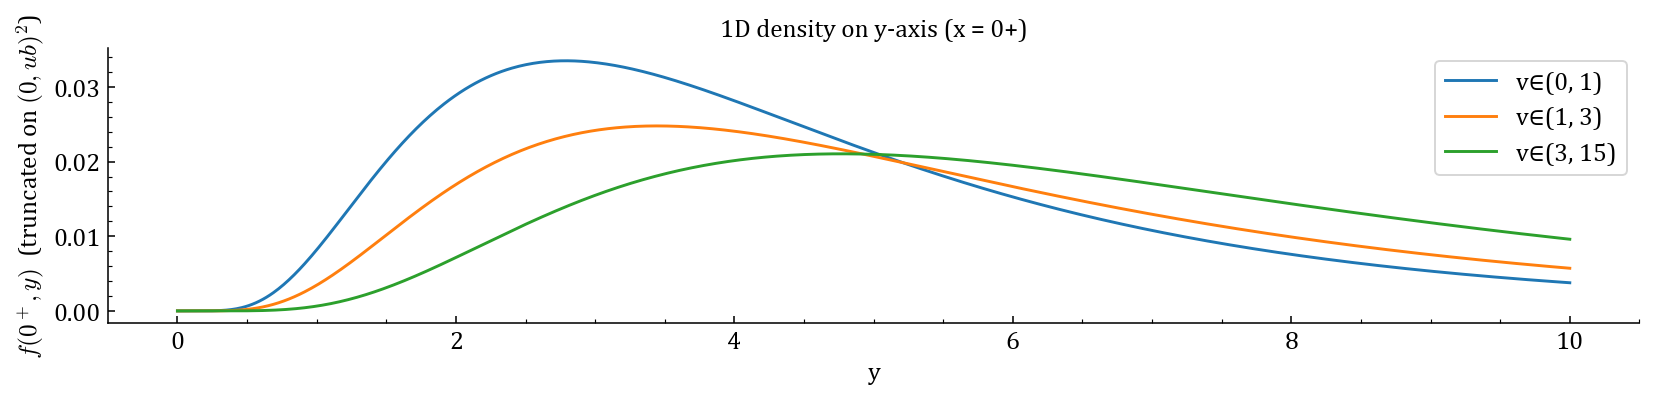

In [24]:
plt.xlabel("x")
plt.ylabel(r"$f(x,0^+)$  (truncated on $(0,ub)^2$)")
plt.title("1D density on x-axis (y = 0+)")
plt.legend()
plt.tight_layout()
# ========= 4B) 一维密度：y 轴切片 (x = 0+)，四条曲线同一张图（可选） =========
plt.figure(figsize=(12,3), dpi=140)
for res, lab in zip(res_list, labels):
    ys, fy = slice_x0_lognorm(res, ub=ub)            # f(0^+, y)
    plt.plot(ys, fy, label=lab)
plt.xlabel("y")
plt.ylabel(r"$f(0^+,y)$  (truncated on $(0,ub)^2$)")
plt.title("1D density on y-axis (x = 0+)")
plt.legend()
plt.tight_layout()

In [7]:
res_list=[{'a': 2.0192738887534705,
  'b': 2.3201198589419834,
  'mu': 0.9305650014060908,
  'sigma': 0.6109550640181163,
  'nll': 112782.31136811928},
 {'a': 2.121198859883311,
  'b': 2.5801449000125936,
  'mu': 1.0635442959911043,
  'sigma': 0.6224895259593011,
  'nll': 114787.6746358353},
 {'a': 2.132066120443428,
  'b': 3.3832000328804206,
  'mu': 1.0424222215052328,
  'sigma': 0.5913722493494209,
  'nll': 23348.55386926538}]

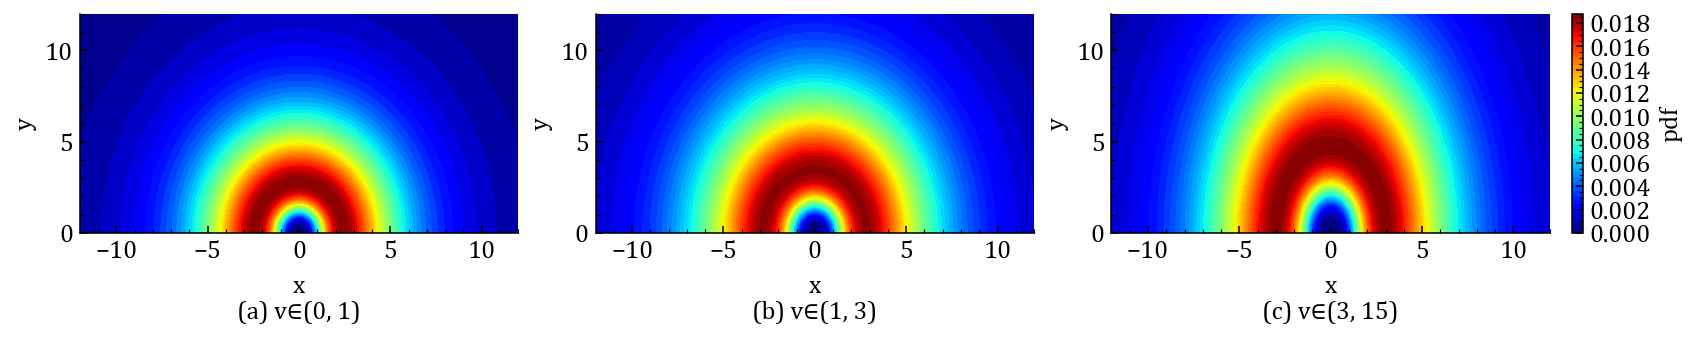

In [11]:
triples = list(zip(res_list[:3], labels[:3]))
fig, axes = plt.subplots(1, 3, figsize=(12, 4.2), constrained_layout=True, dpi=140)
axes = np.ravel(axes)
RENORMALIZE_TO_NEW_DOMAIN = False
mappable = None
# 用 "abc" 直接给小图打标签
for ax, (res, lab), letter in zip(axes, triples, "abc"):
    # 第一象限 (0, ub)^2 的网格与已在该域归一的 pdf
    xs, ys, pdf = normalized_pdf_grid_lognorm(res, ub=12, Mx=420, My=420)

    # 沿 y 轴镜像到 x<0：f(-x, y) = f(x, y)
    xs_full  = np.concatenate((-xs[1:][::-1], xs), axis=0)            # 1D
    pdf_full = np.concatenate((pdf[:, 1:][:, ::-1], pdf), axis=1)     # 2D, 列翻转后拼接
    if RENORMALIZE_TO_NEW_DOMAIN:
        pdf_full = pdf_full / 2.0
    cf = ax.contourf(xs_full, ys, pdf_full, levels=50, cmap='jet')
    ax.set_xlabel(f"x\n({letter}) {lab}", labelpad=6)   # 第二行放 lab
    ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")
    mappable = cf  # 用于共享 colorbar
fig.colorbar(mappable, ax=axes.tolist(), label="pdf", shrink=0.38, pad=0.015)
#plt.savefig('two_ring_fit.png', dpi=220, bbox_inches='tight')
plt.show()

In [12]:
df = pd.read_csv(csv_path)

In [13]:
COL_MAX  = '#FF6F91'  # 导数最大（上升最陡）
COL_ZERO = '#FFC75F'  # 导数=0（众值环）
COL_MIN  = '#845EC2'  # 导数最小（下降最陡）
def rho_keypoints(mu, sigma):
    """返回 (rho_max', rho_0, rho_min')"""
    root = math.sqrt(1.0 + 4.0/(sigma**2))
    rho_max = math.exp(mu - 0.5*(sigma**2)*(5.0 + root))
    rho_0   = math.exp(mu - 2.0*(sigma**2))
    rho_min = math.exp(mu - 0.5*(sigma**2)*(5.0 - root))
    return rho_max, rho_0, rho_min

def ellipse_upper_half_points(a, b, rho, ub, n=720):
    """
    返回上半椭圆轨迹点（覆盖 x<0 与 x>0），并裁剪到 [-ub, ub] × [0, ub]
      参数化：x = a*rho*cos(t), y = b*rho*sin(t), t ∈ [0, π]
    """
    t = np.linspace(0.0, np.pi, n)
    x = a * rho * np.cos(t)
    y = b * rho * np.sin(t)
    m = (x >= -ub) & (x <= ub) & (y >= 0) & (y <= ub)
    return x[m], y[m]

In [14]:
df

Unnamed: 0     tt  id_mor  yy_mor  xx_mor  v_x_mor  v_y_mor     v_mor  \
0                0      2     1.0   641.0   646.0      0.0      0.0  0.000000   
1                1      2     1.0   152.0   165.0      0.0      0.0  0.000000   
2                2      2     1.0   241.0   838.0      0.0      0.0  0.000000   
3                3      2     1.0   241.0   838.0      0.0      0.0  0.000000   
4                4      2     1.0   160.0   281.0      0.0      0.0  0.000000   
...            ...    ...     ...     ...     ...      ...      ...       ...   
311405      311405  14420  7595.0   749.0   368.0      0.0      0.0  0.000000   
311406      311406  14421  7596.0   251.0   802.0      0.0      0.0  0.000000   
311407      311407  14421  7596.0   251.0   802.0      0.0      0.0  0.000000   
311408      311408  14426  7596.0   251.0   793.0     -9.0      0.0  0.004536   
311409      311409  14426  7596.0   251.0   793.0     -9.0      0.0  0.004536   

        id_ped  yy_ped  ...       y_v         v  rel_x  rel_y  near_x  near_y  \
0         18.0   640.0  ...  0.000000  0.000000   25.0   -1.0   0.077   1.925   
1          1.0    95.0  ...  0.000000  0.000000   66.0  -57.0   3.591   4.158   
2          6.0   144.0  ...  0.000000  0.000000   73.0  -97.0   5.238   3.942   
3          4.0    94.0  ...  0.000000  0.000000  -63.0 -147.0   7.938  -3.402   
4          1.0   146.0  ...  0.000000  0.000000  -22.0  -14.0   0.882  -1.386   
...        ...     ...  ...       ...       ...    ...    ...     ...     ...   
311405  9518.0   837.0  ...  0.333333  0.742462    9.0   88.0  -5.544   0.567   
311406  9428.0   160.0  ... -2.000000  1.696327  -34.0  -91.0   5.733  -2.142   
311407  9516.0   219.0  ...  0.666667  2.110474  -22.0  -32.0   2.016  -1.386   
311408  9428.0   160.0  ...  0.000000  1.575000  -29.0  -91.0  -5.733   1.827   
311409  9516.0   219.0  ...  0.000000  0.945000  -19.0  -32.0  -2.016   1.197   

        Distance  angle_radians  angle_degrees  region  
0       1.926539       0.039979       2.290610     1.0  
1       5.494019       0.712358      40.815084     2.0  
2       6.555609       0.925648      53.035711     3.0  
3       8.636287       1.975688     113.198591     6.0  
4       1.642839       2.574863     147.528808     7.0  
...          ...            ...            ...     ...  
311405  5.572919       4.814307     275.839492    13.0  
311406  6.120086       1.928362     110.487014     5.0  
311407  2.446477       2.173084     124.508523     6.0  
311408  6.017077       5.020895     287.676109    13.0  
311409  2.344582       5.248200     300.699723    14.0  

[311410 rows x 25 columns]

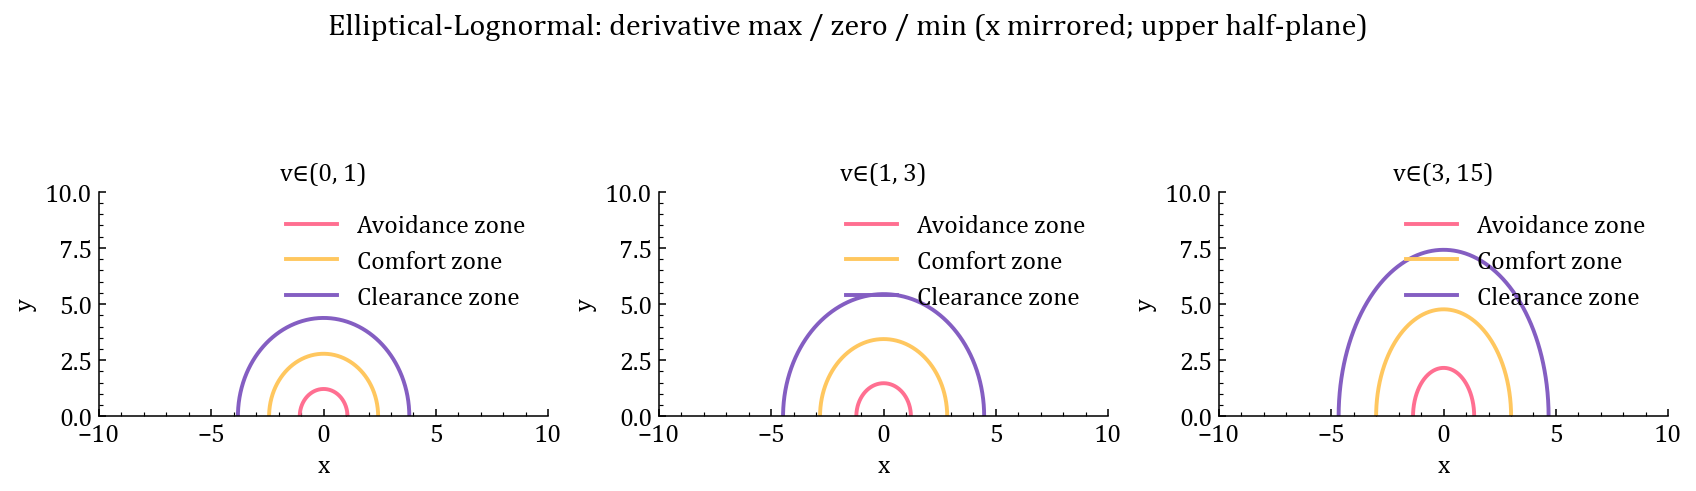

In [15]:
# --- 画图（1x3）---
fig, axes = plt.subplots(1, 3, figsize=(12, 4.2), constrained_layout=True, dpi=140)

mappable = None
for ax, (res, lab) in zip(axes, zip(res_list[:3], labels[:3])):
    a = float(res["a"]); b = float(res["b"])
    mu = float(res["mu"]); sigma = float(res["sigma"])
    # 底图（可选）：第一象限的截断密度；如需也补全到 x<0，可参考你之前的镜像方法
    xs, ys, pdf = normalized_pdf_grid_lognorm(res, ub=ub, Mx=420, My=420)
    mappable = cf
    # 三根线的上半椭圆（覆盖 x<0 与 x>0）
    rho_max, rho_0, rho_min = rho_keypoints(mu, sigma)
    for rho, color, label in [
        (rho_max, COL_MAX,  "Avoidance zone"),
        (rho_0,   COL_ZERO, "Comfort zone"),
        (rho_min, COL_MIN,  "Clearance zone"),
    ]:
        x_line, y_line = ellipse_upper_half_points(a, b, rho, ub)
        if len(x_line) > 1:
            ax.plot(x_line, y_line, color=color, lw=2.0, label=label)
    ax.set_title(lab)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-ub, ub)     # ★ 扩到 x<0
    ax.set_ylim(0,  ub)
    ax.legend(loc="upper right", frameon=False)
fig.suptitle("Elliptical-Lognormal: derivative max / zero / min (x mirrored; upper half-plane)", y=0.995)
plt.show()

In [16]:
df_tianjin=pd.read_csv('combined_data_car_ego_tianjing.csv')
df_tianjin['Distance']=(df_tianjin['near_x']**2+df_tianjin['near_y']**2)**0.5
df_tianjin=df_tianjin[df_tianjin['Distance']<10]

In [17]:
# 小工具：给定一组参数，计算 comfort（向量化）
def comfort_ellip_logn(x, y, a, b, mu, sigma, eps=1e-12):
    rho = np.sqrt((x/a)**2 + (y/b)**2)
    rho_safe = np.maximum(rho, eps)  # 防止 rho=0
    C = 1.0 / (2*np.pi*a*b*sigma*np.sqrt(2*np.pi))
    return C * (rho_safe**-2) * np.exp(-((np.log(rho_safe)-mu)**2) / (2*sigma**2))

# 读取数据列
x = df_tianjin['near_x'].to_numpy()
y = df_tianjin['near_y'].to_numpy()
v = df_tianjin['v'].to_numpy()   # 速度（m/s），用于分段
m0 = (v >= 0.0) & (v < 1.0)
m1 = (v >= 1.0) & (v < 3.0)
m2 = (v >= 3.0) & (v <= 15.0)
comfort = np.full(len(df_tianjin), np.nan, dtype=float)
comfort[m0] = comfort_ellip_logn(x[m0], y[m0],res_list[0]['a'], res_list[0]['b'],res_list[0]['mu'], res_list[0]['sigma'])
comfort[m1] = comfort_ellip_logn(x[m1], y[m1],res_list[1]['a'], res_list[1]['b'],res_list[1]['mu'], res_list[1]['sigma'])
comfort[m2] = comfort_ellip_logn(x[m2], y[m2],res_list[2]['a'], res_list[2]['b'],res_list[2]['mu'], res_list[2]['sigma'])
df_tianjin['comfort'] = comfort

# --- 颜色（可改）---
COL_MAX  = '#FF6F91'  # 导数最大（上升最陡）
COL_ZERO = '#FFC75F'  # 导数=0（众值环）
COL_MIN  = '#845EC2'  # 导数最小（下降最陡）
def rho_keypoints(mu, sigma):
    """返回 (rho_max', rho_0, rho_min')"""
    root = math.sqrt(1.0 + 4.0/(sigma**2))
    rho_max = math.exp(mu - 0.5*(sigma**2)*(5.0 + root))
    rho_0   = math.exp(mu - 2.0*(sigma**2))
    rho_min = math.exp(mu - 0.5*(sigma**2)*(5.0 - root))
    return rho_max, rho_0, rho_min
def ellipse_upper_half_points(a, b, rho, ub, n=720):
    """返回上半椭圆轨迹 (覆盖 x<0 与 x>0), 并裁剪到 [-ub, ub] × [0, ub]"""
    t = np.linspace(0.0, np.pi, n)
    x = a * rho * np.cos(t)
    y = b * rho * np.sin(t)
    m = (x >= -ub) & (x <= ub) & (y >= 0) & (y <= ub)
    return x[m], y[m]
# --- 速度分段（左闭右开，最后一段右闭）：[0,1), [1,3), [3,15] ---
speed_bins = [
    ("v ∈ [0, 1)",  lambda v: (v >= 0.0) & (v < 1.0)),
    ("v ∈ [1, 3)",  lambda v: (v >= 1.0) & (v < 3.0)),
    ("v ∈ [3, 15]", lambda v: (v >= 3.0) & (v <= 15.0)),
]

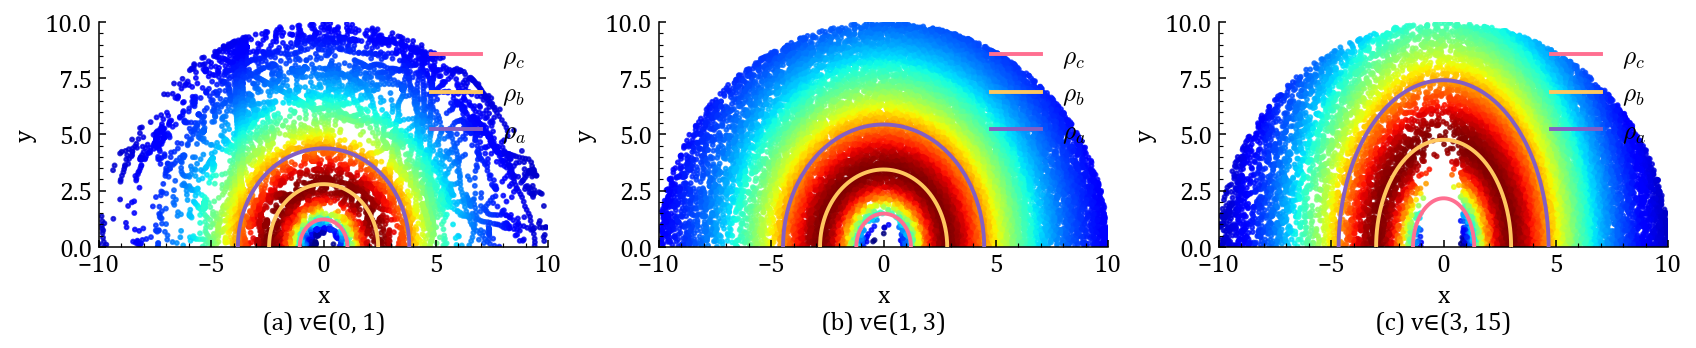

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4.2), constrained_layout=True, dpi=140)
mappable = None
for ax, (res, lab), (range_lab, mask_fn), letter in zip(
    axes,
    zip(res_list[:3], labels[:3]),
    speed_bins[:3],
    "abc"):
    a = float(res["a"]); b = float(res["b"])
    mu = float(res["mu"]); sigma = float(res["sigma"])
    # 1) 底图：第一象限密度 + 沿 x 轴镜像补全到 [-ub, ub] × [0, ub]
    rho_max, rho_0, rho_min = rho_keypoints(mu, sigma)
    for rho, color, label in [
        (rho_max, COL_MAX,  r"$\rho_{c}$"),
        (rho_0,   COL_ZERO, r"$\rho_{b}$"),
        (rho_min, COL_MIN,  r"$\rho_{a}$"),
    ]:
        x_line, y_line = ellipse_upper_half_points(a, b, rho, ub)
        if len(x_line) > 1:
            ax.plot(x_line, y_line, color=color, lw=2.0, label=label, zorder=3)
    # 3) 落点：按速度分段筛 df，并按“半径越小越红”着色（用 jet_r）
    sub = df_tianjin[mask_fn(df_tianjin["v"])].copy()
    if len(sub) > 0:
        # 限制到当前绘图域
        dom = (sub["near_y"] >= 0) & (sub["near_y"] <= ub) & (np.abs(sub["near_x"]) <= ub)
        sub = sub[dom]
    if len(sub) > 0:
        sc = ax.scatter(
            sub["near_x"], sub["near_y"],
            c=sub["comfort"], cmap="jet",  # 反转使半径越小越红
            s=4,alpha=0.8)
        # 可选：也为点加专属 colorbar（注释掉即不显示）
        # plt.colorbar(sc, ax=ax, shrink=0.8, label="elliptical radius ρ")
    # ax.set_title(f"{lab}\n{range_lab}")
    ax.set_xlabel(f"x\n({letter}) {lab}"); ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-ub, ub); ax.set_ylim(0, ub)
    ax.legend(loc="upper right", frameon=False)
# 共享色条（底图密度）
#fig.suptitle("Elliptical-Lognormal density + key ellipses + points by speed bins", y=0.995)
#plt.savefig('tianjin.png', dpi=220, bbox_inches='tight')
plt.show()

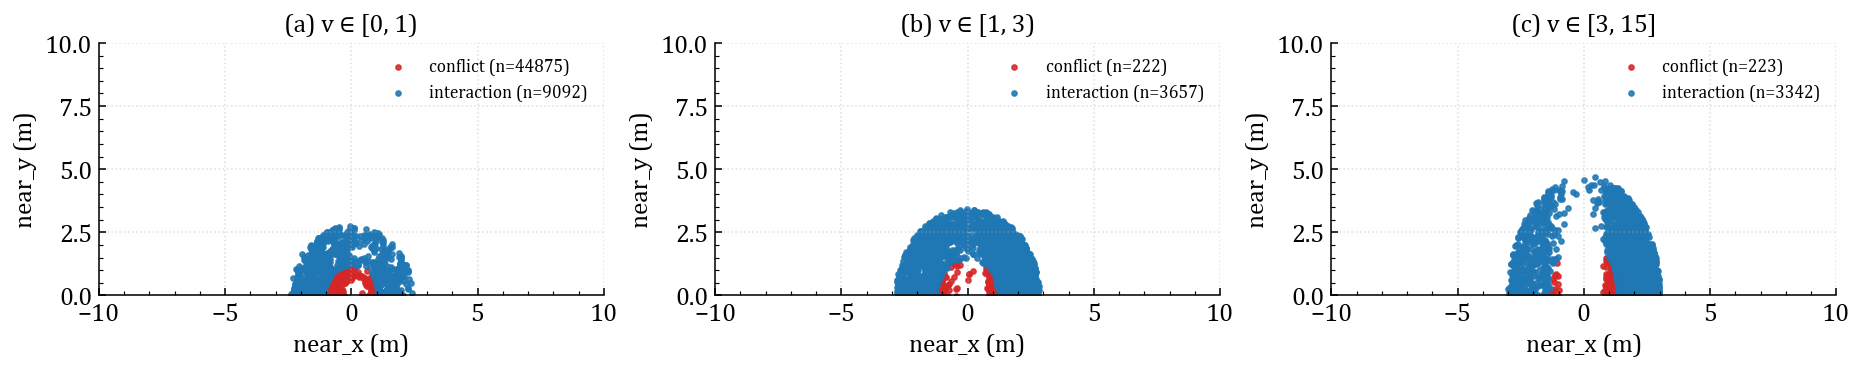

In [19]:
assert len(res_list) >= 3, "res_list 至少需要包含 3 组参数（对应三段速度层）"
ci_label = np.full(len(df_tianjin), 'other', dtype=object)  # 默认 other，不参与作图
for idx, (_, mask_fn) in enumerate(speed_bins):
    m = mask_fn(v)               # 当前层样本掩码
    if not np.any(m):
        continue
    a = float(res_list[idx]['a']); b = float(res_list[idx]['b'])
    mu = float(res_list[idx]['mu']); sigma = float(res_list[idx]['sigma'])
    rho = np.sqrt((x[m]/a)**2 + (y[m]/b)**2)
    rho_c, rho_b, rho_a = rho_keypoints(mu, sigma)
    # 本层内局部掩码（相对 m 的索引）
    conflict_local    = (rho < rho_c)
    interaction_local = (rho >= rho_c) & (rho < rho_b)
    interaction_local_1 = (rho >= rho_b) & (rho < rho_a)
    # 映射回全局索引再赋值
    idx_m = np.flatnonzero(m)
    ci_label[idx_m[conflict_local]]    = 'conflict'
    ci_label[idx_m[interaction_local]] = 'interaction'
    ci_label[idx_m[interaction_local_1]] = 'interaction_1'
df_tianjin['ci_label'] = pd.Categorical(ci_label, categories=['conflict','interaction','interaction_1','other'])

# ========= 可视化：一行三列，仅绘制 conflict 与 interaction =========
COLOR = {'conflict': '#d62728', 'interaction': '#1f77b4'}
fig, axes = plt.subplots(1, 3, figsize=(13.2, 4.2), dpi=140, constrained_layout=True)

for ax, (title_txt, mask_fn), letter in zip(axes, speed_bins, "abc"):
    sub = df_tianjin[mask_fn(df_tianjin['v'])].copy()
    ax.set_title(f"({letter}) {title_txt}")
    ax.set_xlabel("near_x (m)")
    ax.set_ylabel("near_y (m)")
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-ub, ub)
    ax.set_ylim(0, ub)
    ax.grid(True, ls=":", alpha=0.4)

    if len(sub) == 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
        continue

    for lab in ['conflict', 'interaction']:
        m_lab = (sub['ci_label'] == lab)
        if m_lab.any():
            ax.scatter(sub.loc[m_lab, 'near_x'], sub.loc[m_lab, 'near_y'],
                       s=6, alpha=0.85, c=COLOR[lab], label=f"{lab} (n={m_lab.sum()})")

    ax.legend(loc="upper right", frameon=False, fontsize=9)
plt.show()

In [20]:
W, H = 3840, 2160
X_L, X_R = 20.99, 55.51
Y_T, Y_B = 4.643, 38.69
sx = W / (X_L + X_R)
sy = H / (Y_T + Y_B)
df_sub = df_tianjin[df_tianjin['ci_label'].astype('string').isin(['interaction','conflict'])].copy()
df_sub = df_sub[np.isfinite(df_sub['comfort'])]
x = -df_sub['comfort'].to_numpy(dtype=float)
risk_norm = (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x) + 1e-12)
df_sub['risk_norm'] = risk_norm
# 坐标映射到像素
x_px = df_sub['x_car'].to_numpy() * sx + X_L * sx
y_px = df_sub['y_car'].to_numpy() * sy + Y_T * sy
# ===== 2) 在像素网格上求每格平均风险 =====
nx, ny =190,105  # 网格分辨率
# 权重求和（风险之和）
sum_risk, xedges, yedges = np.histogram2d(
    x_px, y_px, bins=[nx, ny], range=[[0, W], [0, H]], weights=risk_norm)
cnt, _, _ = np.histogram2d(
    x_px, y_px, bins=[nx, ny], range=[[0, W], [0, H]])
# 平均风险（避免除零）
mean_risk = np.full_like(sum_risk, np.nan, dtype=float)
m = cnt > 0
mean_risk[m] = sum_risk[m] / cnt[m]
# 转为 (ny, nx)，并取网格中心点
Z = mean_risk.T
xc = 0.5 * (xedges[:-1] + xedges[1:])
yc = 0.5 * (yedges[:-1] + yedges[1:])
Xc, Yc = np.meshgrid(xc, yc, indexing='xy')  # 形状 (ny, nx)
finite_Z = Z[np.isfinite(Z)]
if finite_Z.size == 0:
    raise RuntimeError("No finite risk values to contour. Check data or bins.")
levels = np.quantile(finite_Z, np.linspace(0.15, 0.95, 9))  # 9条等势线
# ===== 5) 叠加到底图，用 contour 可视化等势线 =====
fig, ax = plt.subplots(figsize=(6,3), dpi=140)
img = plt.imread(r'C:/Users/14487/python-book/驾驶员让行模拟论文/第一轮修改/tianjin.jpg')
ax.imshow(img, extent=[0, W, 0, H], origin='upper', alpha=0.85, zorder=1)
# Z 是你要等高线的二维网格（形状 ~ (ny, nx)）
Z[np.isnan(Z)] = 0.0
Z_smooth = gaussian_filter(Z, sigma=1.0, mode='nearest')  # sigma≈2–4 个网格为常用范围
CS = ax.contour(Xc, Yc, Z_smooth, levels=8, cmap='jet', linewidths=1, zorder=2)
cbar = plt.colorbar(CS, ax=ax, fraction=0.027, pad=0.02)
cbar.set_label('Interaction risk')
ax.set_xlim(0, W)
ax.set_ylim(0, H)            # 与 origin='upper' 一致，上小下大

plt.tight_layout()
plt.savefig('tianjin_conflict_risk_contour.png', dpi=220, bbox_inches='tight')
plt.show()

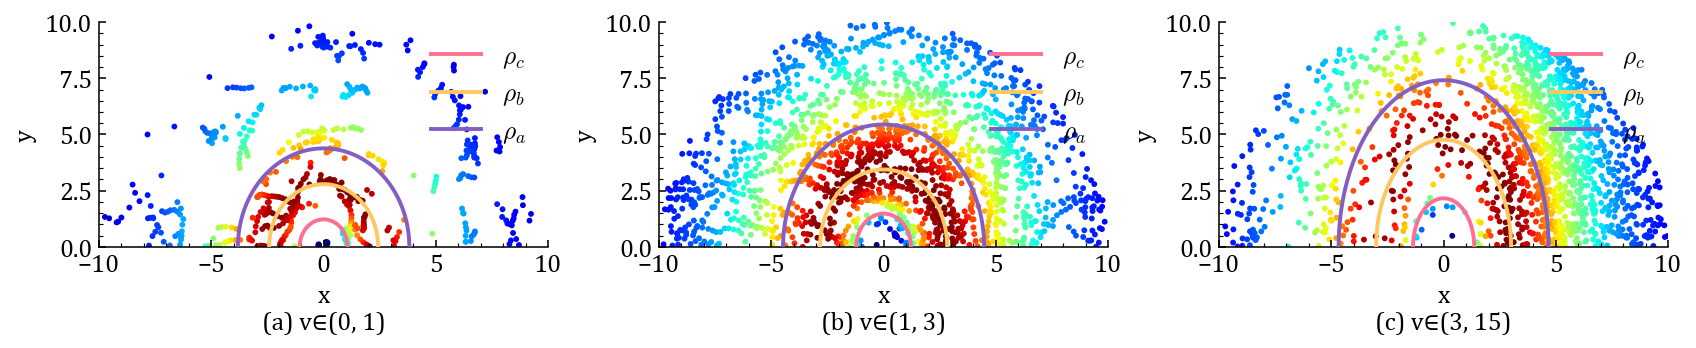

In [21]:
df_changchun=pd.read_csv('combined_data_car_ego_changchun.csv')
df_changchun['Distance']=(df_changchun['near_x']**2+df_changchun['near_y']**2)**0.5
df_changchun=df_changchun[df_changchun['Distance']<10]
x = df_changchun['near_x'].to_numpy()
y = df_changchun['near_y'].to_numpy()
v = df_changchun['v'].to_numpy()   # 速度（m/s），用于分段
m0 = (v >= 0.0) & (v < 1.0)
m1 = (v >= 1.0) & (v < 3.0)
m2 = (v >= 3.0) & (v <= 15.0)
comfort = np.full(len(df_changchun), np.nan, dtype=float)
comfort[m0] = comfort_ellip_logn(x[m0], y[m0],res_list[0]['a'], res_list[0]['b'],res_list[0]['mu'], res_list[0]['sigma'])
comfort[m1] = comfort_ellip_logn(x[m1], y[m1],res_list[1]['a'], res_list[1]['b'],res_list[1]['mu'], res_list[1]['sigma'])
comfort[m2] = comfort_ellip_logn(x[m2], y[m2],res_list[2]['a'], res_list[2]['b'],res_list[2]['mu'], res_list[2]['sigma'])
df_changchun['comfort'] = comfort
# --- 颜色（可改）---
COL_MAX  = '#FF6F91'  # 导数最大（上升最陡）
COL_ZERO = '#FFC75F'  # 导数=0（众值环）
COL_MIN  = '#845EC2'  # 导数最小（下降最陡）
# --- 速度分段（左闭右开，最后一段右闭）：[0,1), [1,3), [3,15] ---
speed_bins = [
    ("v ∈ [0, 1)",  lambda v: (v >= 0.0) & (v < 1.0)),
    ("v ∈ [1, 3)",  lambda v: (v >= 1.0) & (v < 3.0)),
    ("v ∈ [3, 15]", lambda v: (v >= 3.0) & (v <= 15.0)),]
fig, axes = plt.subplots(1, 3, figsize=(12, 4.2), constrained_layout=True, dpi=140)
mappable = None
for ax, (res, lab), (range_lab, mask_fn), letter in zip(
    axes,
    zip(res_list[:3], labels[:3]),
    speed_bins[:3],
    "abc"):
    a = float(res["a"]); b = float(res["b"])
    mu = float(res["mu"]); sigma = float(res["sigma"])
    # 1) 底图：第一象限密度 + 沿 x 轴镜像补全到 [-ub, ub] × [0, ub]

    rho_max, rho_0, rho_min = rho_keypoints(mu, sigma)
    for rho, color, label in [
        (rho_max, COL_MAX,  r"$\rho_{c}$"),
        (rho_0,   COL_ZERO, r"$\rho_{b}$"),
        (rho_min, COL_MIN,  r"$\rho_{a}$"),
    ]:
        x_line, y_line = ellipse_upper_half_points(a, b, rho, ub)
        if len(x_line) > 1:
            ax.plot(x_line, y_line, color=color, lw=2.0, label=label, zorder=3)
    # 3) 落点：按速度分段筛 df，并按“半径越小越红”着色（用 jet_r）
    sub = df_changchun[mask_fn(df_changchun["v"])].copy()
    if len(sub) > 0:
        # 限制到当前绘图域
        dom = (sub["near_y"] >= 0) & (sub["near_y"] <= ub) & (np.abs(sub["near_x"]) <= ub)
        sub = sub[dom]
    if len(sub) > 0:
        rho_pts = np.sqrt( (sub["near_x"]/a)**2 + (sub["near_y"]/b)**2 )
        sc = ax.scatter(
            sub["near_x"], sub["near_y"],
            c=sub["comfort"], cmap="jet",  # 反转使半径越小越红
            s=4  )
        # 可选：也为点加专属 colorbar（注释掉即不显示）
        # plt.colorbar(sc, ax=ax, shrink=0.8, label="elliptical radius ρ")
    # ax.set_title(f"{lab}\n{range_lab}")
    ax.set_xlabel(f"x\n({letter}) {lab}"); ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-ub, ub); ax.set_ylim(0, ub)
    ax.legend(loc="upper right", frameon=False)
# 共享色条（底图密度）
#plt.savefig('changchun.png', dpi=220, bbox_inches='tight')
plt.show()

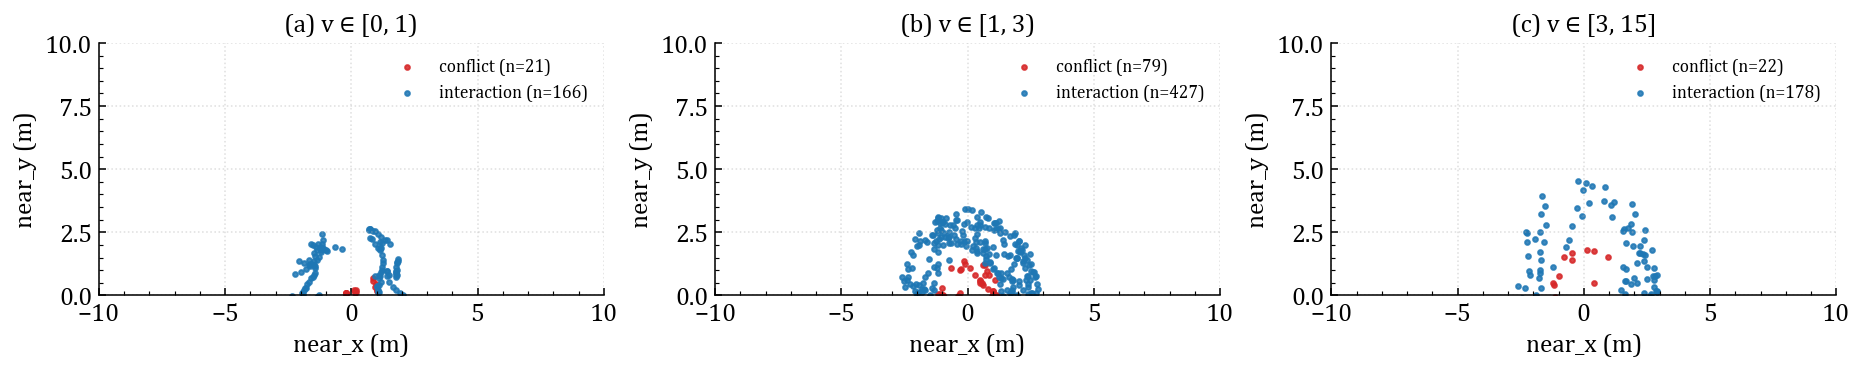

In [22]:
assert len(res_list) >= 3, "res_list 至少需要包含 3 组参数（对应三段速度层）"
ci_label = np.full(len(df_changchun), 'other', dtype=object)  # 默认 other，不参与作图
for idx, (_, mask_fn) in enumerate(speed_bins):
    m = mask_fn(v)               # 当前层样本掩码
    if not np.any(m):
        continue
    a = float(res_list[idx]['a']); b = float(res_list[idx]['b'])
    mu = float(res_list[idx]['mu']); sigma = float(res_list[idx]['sigma'])
    rho = np.sqrt((x[m]/a)**2 + (y[m]/b)**2)
    rho_c, rho_b, rho_a = rho_keypoints(mu, sigma)
    # 本层内局部掩码（相对 m 的索引）
    conflict_local    = (rho < rho_c)
    interaction_local = (rho >= rho_c) & (rho < rho_b)
    interaction_local_1 = (rho >= rho_b) & (rho < rho_a)
    # 映射回全局索引再赋值
    idx_m = np.flatnonzero(m)
    ci_label[idx_m[conflict_local]]    = 'conflict'
    ci_label[idx_m[interaction_local]] = 'interaction'
    ci_label[idx_m[interaction_local_1]] = 'interaction_1'
df_changchun['ci_label'] = pd.Categorical(ci_label, categories=['conflict','interaction','interaction_1','other'])
# ========= 可视化：一行三列，仅绘制 conflict 与 interaction =========
COLOR = {'conflict': '#d62728', 'interaction': '#1f77b4'}
fig, axes = plt.subplots(1, 3, figsize=(13.2, 4.2), dpi=140, constrained_layout=True)
for ax, (title_txt, mask_fn), letter in zip(axes, speed_bins, "abc"):
    sub = df_changchun[mask_fn(df_changchun['v'])].copy()
    ax.set_title(f"({letter}) {title_txt}")
    ax.set_xlabel("near_x (m)")
    ax.set_ylabel("near_y (m)")
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-ub, ub)
    ax.set_ylim(0, ub)
    ax.grid(True, ls=":", alpha=0.4)
    if len(sub) == 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
        continue
    for lab in ['conflict', 'interaction']:
        m_lab = (sub['ci_label'] == lab)
        if m_lab.any():
            ax.scatter(sub.loc[m_lab, 'near_x'], sub.loc[m_lab, 'near_y'],
                       s=6, alpha=0.85, c=COLOR[lab], label=f"{lab} (n={m_lab.sum()})")
    ax.legend(loc="upper right", frameon=False, fontsize=9)
plt.show()

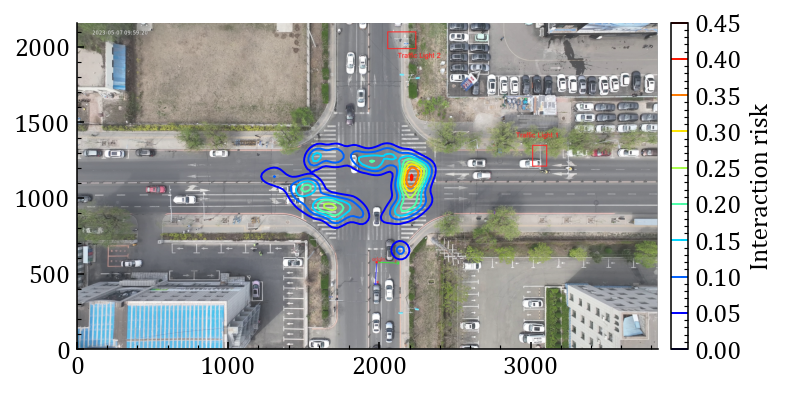

In [23]:
# ===== 基本参数：背景图 & 像素映射（保持与你一致）=====
W, H = 3840, 2160
X_L, X_R = 94.92, 53.74
Y_T, Y_B = 82.79, 75.87
sx = W / (X_L + X_R)
sy = H / (Y_T + Y_B)
# ===== 1) 筛选 + 定义冲突风险 =====
df_sub = df_changchun[df_changchun['ci_label'].astype('string').isin(['interaction','conflict'])].copy()
df_sub = df_sub[np.isfinite(df_sub['comfort'])]
x = -df_sub['comfort'].to_numpy(dtype=float)
risk_norm = (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x) + 1e-12)
df_sub['risk_norm'] = risk_norm
# 坐标映射到像素
x_px = df_sub['x_car'].to_numpy() * sx + X_L * sx
y_px = df_sub['y_car'].to_numpy() * sy + Y_T * sy
# ===== 2) 在像素网格上求每格平均风险 =====
nx, ny =190,105  # 网格分辨率
# 权重求和（风险之和）
sum_risk, xedges, yedges = np.histogram2d(
    x_px, y_px, bins=[nx, ny], range=[[0, W], [0, H]], weights=risk_norm)
# 计数
cnt, _, _ = np.histogram2d(
    x_px, y_px, bins=[nx, ny], range=[[0, W], [0, H]])
# 平均风险（避免除零）
mean_risk = np.full_like(sum_risk, np.nan, dtype=float)
m = cnt > 0
mean_risk[m] = sum_risk[m] / cnt[m]
# 转为 (ny, nx)，并取网格中心点
Z = mean_risk.T
xc = 0.5 * (xedges[:-1] + xedges[1:])
yc = 0.5 * (yedges[:-1] + yedges[1:])
Xc, Yc = np.meshgrid(xc, yc, indexing='xy')  # 形状 (ny, nx)
finite_Z = Z[np.isfinite(Z)]
if finite_Z.size == 0:
    raise RuntimeError("No finite risk values to contour. Check data or bins.")
levels = np.quantile(finite_Z, np.linspace(0.15, 0.95, 9))  # 9条等势线
# ===== 5) 叠加到底图，用 contour 可视化等势线 =====
fig, ax = plt.subplots(figsize=(6,3), dpi=140)
img = plt.imread(r'C:/Users/14487/python-book/驾驶员让行模拟论文/第一轮修改/SinD/Changchun_Pudong/Changchun_Pudong.png')
ax.imshow(img, extent=[0, W, 0, H], origin='upper', alpha=0.85, zorder=1)
# Z 是你要等高线的二维网格（形状 ~ (ny, nx)）
Z[np.isnan(Z)] = 0.01
Z_smooth = gaussian_filter(Z, sigma=2, mode='nearest')  # sigma≈2–4 个网格为常用范围
CS = ax.contour( Xc, Yc, Z_smooth, levels=8, cmap='jet', linewidths=1, zorder=2)
cbar = plt.colorbar(CS, ax=ax, fraction=0.027, pad=0.02)
cbar.set_label('Interaction risk')
ax.set_xlim(0, W)
ax.set_ylim(0, H)            # 与 origin='upper' 一致，上小下大
#ax.set_title('Isocontours of conflict risk (mean per cell)')
plt.tight_layout()
plt.savefig('changchun_conflict_risk_contour.png', dpi=220, bbox_inches='tight')
plt.show()

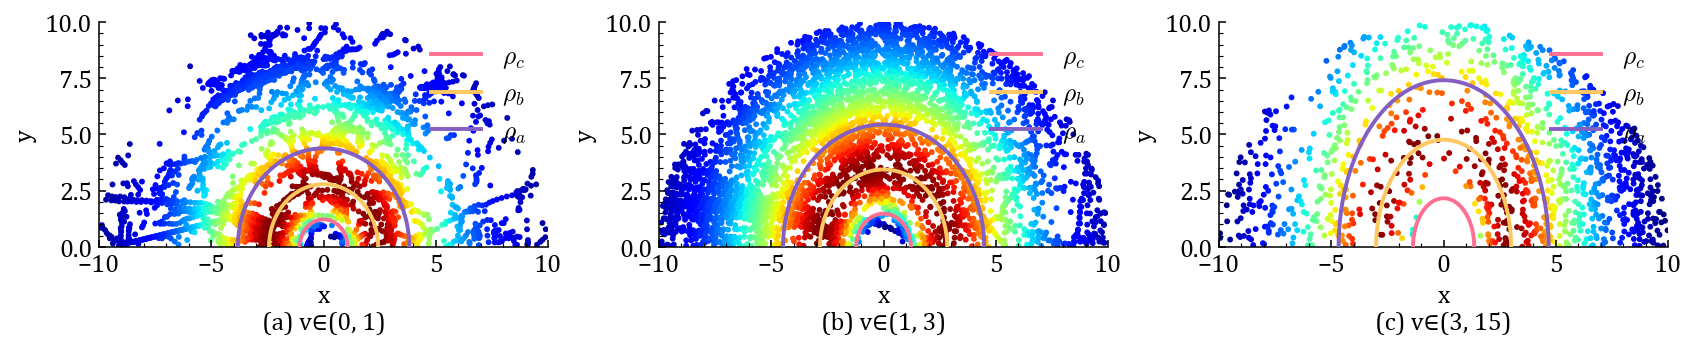

In [24]:
df_chongqing=pd.read_csv('combined_data_car_ego_chongqing.csv')
df_chongqing['Distance']=(df_chongqing['near_x']**2+df_chongqing['near_y']**2)**0.5
df_chongqing=df_chongqing[df_chongqing['Distance']<10]

x = df_chongqing['near_x'].to_numpy()
y = df_chongqing['near_y'].to_numpy()
v = df_chongqing['v'].to_numpy()   # 速度（m/s），用于分段
m0 = (v >= 0.0) & (v < 1.0)
m1 = (v >= 1.0) & (v < 3.0)
m2 = (v >= 3.0) & (v <= 15.0)
comfort = np.full(len(df_chongqing), np.nan, dtype=float)
comfort[m0] = comfort_ellip_logn(x[m0], y[m0],res_list[0]['a'], res_list[0]['b'],res_list[0]['mu'], res_list[0]['sigma'])
comfort[m1] = comfort_ellip_logn(x[m1], y[m1],res_list[1]['a'], res_list[1]['b'],res_list[1]['mu'], res_list[1]['sigma'])
comfort[m2] = comfort_ellip_logn(x[m2], y[m2],res_list[2]['a'], res_list[2]['b'],res_list[2]['mu'], res_list[2]['sigma'])
df_chongqing['comfort'] = comfort

# --- 颜色（可改）---
COL_MAX  = '#FF6F91'  # 导数最大（上升最陡）
COL_ZERO = '#FFC75F'  # 导数=0（众值环）
COL_MIN  = '#845EC2'  # 导数最小（下降最陡）


# --- 速度分段（左闭右开，最后一段右闭）：[0,1), [1,3), [3,15] ---
speed_bins = [
    ("v ∈ [0, 1)",  lambda v: (v >= 0.0) & (v < 1.0)),
    ("v ∈ [1, 3)",  lambda v: (v >= 1.0) & (v < 3.0)),
    ("v ∈ [3, 15]", lambda v: (v >= 3.0) & (v <= 15.0)),
]
fig, axes = plt.subplots(1, 3, figsize=(12, 4.2), constrained_layout=True, dpi=140)
mappable = None
for ax, (res, lab), (range_lab, mask_fn), letter in zip(
    axes,
    zip(res_list[:3], labels[:3]),
    speed_bins[:3],
    "abc"
):
    a = float(res["a"]); b = float(res["b"])
    mu = float(res["mu"]); sigma = float(res["sigma"])
    # 1) 底图：第一象限密度 + 沿 x 轴镜像补全到 [-ub, ub] × [0, ub]

    rho_max, rho_0, rho_min = rho_keypoints(mu, sigma)
    for rho, color, label in [
        (rho_max, COL_MAX,  r"$\rho_{c}$"),
        (rho_0,   COL_ZERO, r"$\rho_{b}$"),
        (rho_min, COL_MIN,  r"$\rho_{a}$"),
    ]:
        x_line, y_line = ellipse_upper_half_points(a, b, rho, ub)
        if len(x_line) > 1:
            ax.plot(x_line, y_line, color=color, lw=2.0, label=label, zorder=3)
    # 3) 落点：按速度分段筛 df，并按“半径越小越红”着色（用 jet_r）
    sub = df_chongqing[mask_fn(df_chongqing["v"])].copy()
    if len(sub) > 0:
        # 限制到当前绘图域
        dom = (sub["near_y"] >= 0) & (sub["near_y"] <= ub) & (np.abs(sub["near_x"]) <= ub)
        sub = sub[dom]
    if len(sub) > 0:
        rho_pts = np.sqrt( (sub["near_x"]/a)**2 + (sub["near_y"]/b)**2 )
        sc = ax.scatter(
            sub["near_x"], sub["near_y"],
            c=sub["comfort"], cmap="jet",  # 反转使半径越小越红
            s=4  )
        # 可选：也为点加专属 colorbar（注释掉即不显示）
        # plt.colorbar(sc, ax=ax, shrink=0.8, label="elliptical radius ρ")
    # ax.set_title(f"{lab}\n{range_lab}")
    ax.set_xlabel(f"x\n({letter}) {lab}"); ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-ub, ub); ax.set_ylim(0, ub)
    ax.legend(loc="upper right", frameon=False)
# 共享色条（底图密度）
#plt.savefig('chongqing.png', dpi=220, bbox_inches='tight')
plt.show()

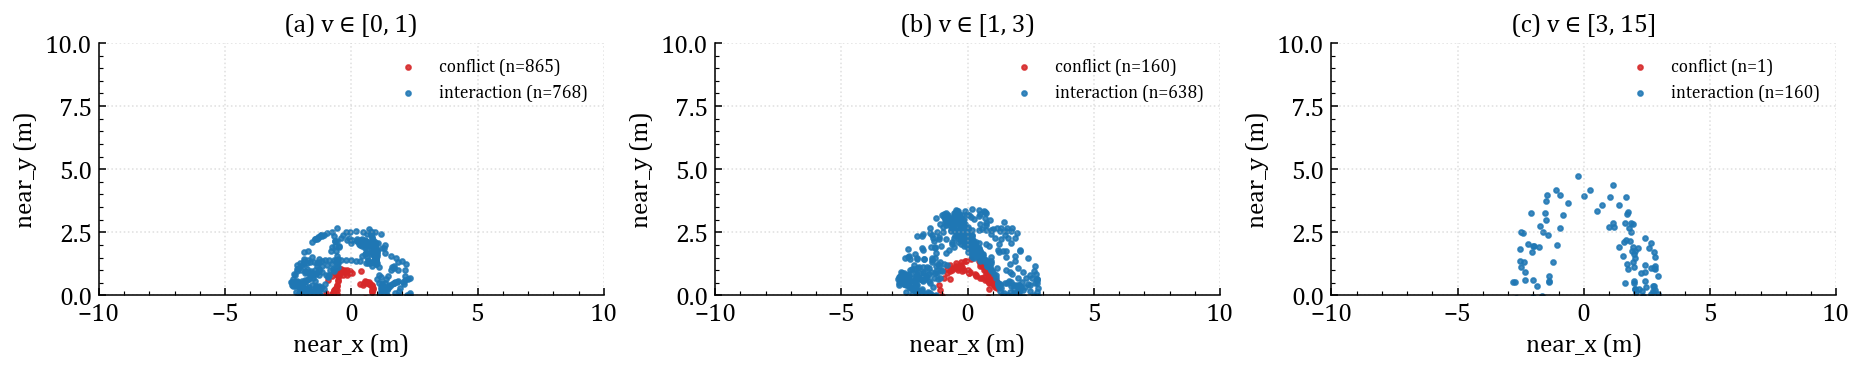

In [25]:
assert len(res_list) >= 3, "res_list 至少需要包含 3 组参数（对应三段速度层）"
ci_label = np.full(len(df_chongqing), 'other', dtype=object)  # 默认 other，不参与作图
for idx, (_, mask_fn) in enumerate(speed_bins):
    m = mask_fn(v)               # 当前层样本掩码
    if not np.any(m):
        continue
    a = float(res_list[idx]['a']); b = float(res_list[idx]['b'])
    mu = float(res_list[idx]['mu']); sigma = float(res_list[idx]['sigma'])
    rho = np.sqrt((x[m]/a)**2 + (y[m]/b)**2)
    rho_c, rho_b, rho_a = rho_keypoints(mu, sigma)
    # 本层内局部掩码（相对 m 的索引）
    conflict_local    = (rho < rho_c)
    interaction_local = (rho >= rho_c) & (rho < rho_b)
    interaction_local_1 = (rho >= rho_b) & (rho < rho_a)
    # 映射回全局索引再赋值
    idx_m = np.flatnonzero(m)
    ci_label[idx_m[conflict_local]]    = 'conflict'
    ci_label[idx_m[interaction_local]] = 'interaction'
    ci_label[idx_m[interaction_local_1]] = 'interaction_1'
df_chongqing['ci_label'] = pd.Categorical(ci_label, categories=['conflict','interaction','interaction_1','other'])
# ========= 可视化：一行三列，仅绘制 conflict 与 interaction =========
COLOR = {'conflict': '#d62728', 'interaction': '#1f77b4'}
fig, axes = plt.subplots(1, 3, figsize=(13.2, 4.2), dpi=140, constrained_layout=True)

for ax, (title_txt, mask_fn), letter in zip(axes, speed_bins, "abc"):
    sub = df_chongqing[mask_fn(df_chongqing['v'])].copy()
    ax.set_title(f"({letter}) {title_txt}")
    ax.set_xlabel("near_x (m)")
    ax.set_ylabel("near_y (m)")
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-ub, ub)
    ax.set_ylim(0, ub)
    ax.grid(True, ls=":", alpha=0.4)

    if len(sub) == 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
        continue

    for lab in ['conflict', 'interaction']:
        m_lab = (sub['ci_label'] == lab)
        if m_lab.any():
            ax.scatter(sub.loc[m_lab, 'near_x'], sub.loc[m_lab, 'near_y'],
                       s=6, alpha=0.85, c=COLOR[lab], label=f"{lab} (n={m_lab.sum()})")

    ax.legend(loc="upper right", frameon=False, fontsize=9)
plt.show()

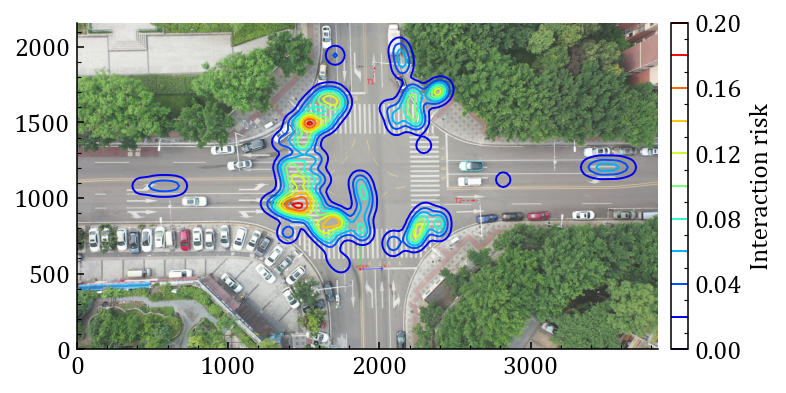

In [26]:
# ===== 基本参数：背景图 & 像素映射（保持与你一致）=====
W, H = 3840, 2160
X_L, X_R = 44.9, 51
Y_T, Y_B = 26.4, 51.4
sx = W / (X_L + X_R)
sy = H / (Y_T + Y_B)
# ===== 1) 筛选 + 定义冲突风险 =====
df_sub = df_chongqing[df_chongqing['ci_label'].astype('string').isin(['interaction','conflict'])].copy()
df_sub = df_sub[np.isfinite(df_sub['comfort'])]
x = -df_sub['comfort'].to_numpy(dtype=float)
risk_norm = (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x) + 1e-12)
df_sub['risk_norm'] = risk_norm
# 坐标映射到像素
x_px = df_sub['x_car'].to_numpy() * sx + X_L * sx+200
y_px = df_sub['y_car'].to_numpy() * sy + Y_T * sy
# ===== 2) 在像素网格上求每格平均风险 =====
nx, ny =190,105  # 网格分辨率
# 权重求和（风险之和）
sum_risk, xedges, yedges = np.histogram2d(
    x_px, y_px, bins=[nx, ny], range=[[0, W], [0, H]], weights=risk_norm)
# 计数
cnt, _, _ = np.histogram2d(
    x_px, y_px, bins=[nx, ny], range=[[0, W], [0, H]])
# 平均风险（避免除零）
mean_risk = np.full_like(sum_risk, np.nan, dtype=float)
m = cnt > 0
mean_risk[m] = sum_risk[m] / cnt[m]
# 转为 (ny, nx)，并取网格中心点
Z = mean_risk.T
xc = 0.5 * (xedges[:-1] + xedges[1:])
yc = 0.5 * (yedges[:-1] + yedges[1:])
Xc, Yc = np.meshgrid(xc, yc, indexing='xy')  # 形状 (ny, nx)
finite_Z = Z[np.isfinite(Z)]
if finite_Z.size == 0:
    raise RuntimeError("No finite risk values to contour. Check data or bins.")
levels = np.quantile(finite_Z, np.linspace(0.15, 0.95, 9))  # 9条等势线
# ===== 5) 叠加到底图，用 contour 可视化等势线 =====
fig, ax = plt.subplots(figsize=(6,3), dpi=140)
img = plt.imread(r'C:/Users/14487/python-book/驾驶员让行模拟论文/第一轮修改/SinD/Chongqing_NR/Chongqing_NR.png')
ax.imshow(img, extent=[0, W, 0, H], origin='upper', alpha=0.85, zorder=1)
# Z 是你要等高线的二维网格（形状 ~ (ny, nx)）
Z[np.isnan(Z)] = 0.01
Z_smooth = gaussian_filter(Z, sigma=2, mode='nearest')  # sigma≈2–4 个网格为常用范围
CS = ax.contour( Xc, Yc, Z_smooth, levels=8, cmap='jet', linewidths=1, zorder=2)
cbar = plt.colorbar(CS, ax=ax, fraction=0.027, pad=0.02)
cbar.set_label('Interaction risk')
ax.set_xlim(0, W)
ax.set_ylim(0, H)            # 与 origin='upper' 一致，上小下大
plt.tight_layout()
plt.savefig('chongqing_conflict_risk_contour.png', dpi=220, bbox_inches='tight')
plt.show()

C:\Users\14487\anaconda3\envs\MARL\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\14487\anaconda3\envs\MARL\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\14487\anaconda3\envs\MARL\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


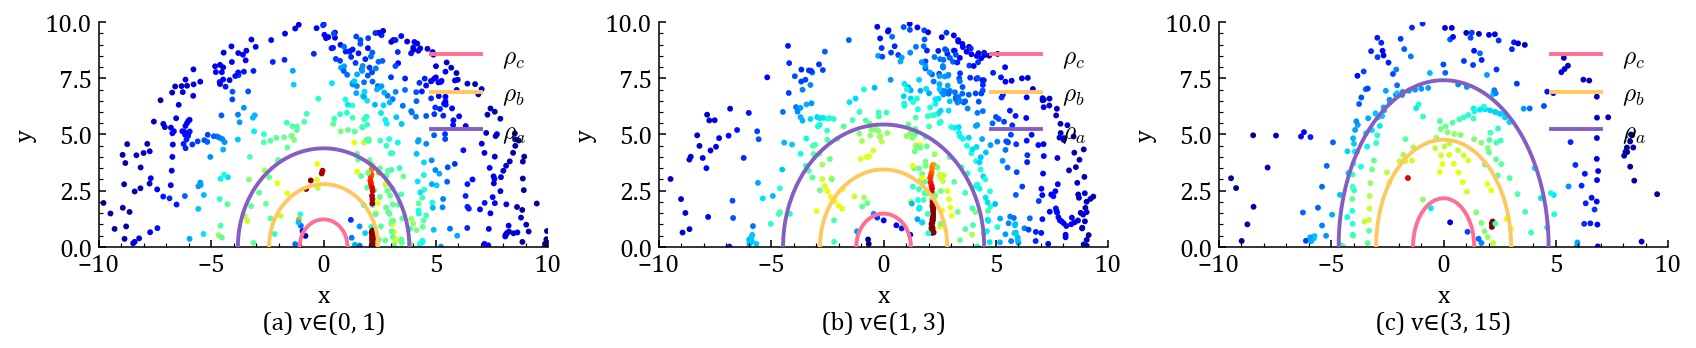

In [27]:
df_xian=pd.read_csv('combined_data_car_ego_xian.csv')
df_xian['Distance']=(df_xian['near_x']**2+df_xian['near_y']**2)**0.5
df_xian=df_xian[df_xian['Distance']<10]
x = df_xian['near_x'].to_numpy()
y = df_xian['near_y'].to_numpy()
v = df_xian['v'].to_numpy()   # 速度（m/s），用于分段
m0 = (v >= 0.0) & (v < 1.0)
m1 = (v >= 1.0) & (v < 3.0)
m2 = (v >= 3.0) & (v <= 15.0)
comfort = np.full(len(df_xian), np.nan, dtype=float)
comfort[m0] = comfort_ellip_logn(x[m0], y[m0],res_list[0]['a'], res_list[0]['b'],res_list[0]['mu'], res_list[0]['sigma'])
comfort[m1] = comfort_ellip_logn(x[m1], y[m1],res_list[1]['a'], res_list[1]['b'],res_list[1]['mu'], res_list[1]['sigma'])
comfort[m2] = comfort_ellip_logn(x[m2], y[m2],res_list[2]['a'], res_list[2]['b'],res_list[2]['mu'], res_list[2]['sigma'])
df_xian['comfort'] = comfort
# --- 颜色（可改）---
COL_MAX  = '#FF6F91'  # 导数最大（上升最陡）
COL_ZERO = '#FFC75F'  # 导数=0（众值环）
COL_MIN  = '#845EC2'  # 导数最小（下降最陡）
# --- 速度分段（左闭右开，最后一段右闭）：[0,1), [1,3), [3,15] ---
speed_bins = [
    ("v ∈ [0, 1)",  lambda v: (v >= 0.0) & (v < 1.0)),
    ("v ∈ [1, 3)",  lambda v: (v >= 1.0) & (v < 3.0)),
    ("v ∈ [3, 15]", lambda v: (v >= 3.0) & (v <= 15.0)),
]
fig, axes = plt.subplots(1, 3, figsize=(12, 4.2), constrained_layout=True, dpi=140)
mappable = None
for ax, (res, lab), (range_lab, mask_fn), letter in zip(
    axes,
    zip(res_list[:3], labels[:3]),
    speed_bins[:3],
    "abc"
):
    a = float(res["a"]); b = float(res["b"])
    mu = float(res["mu"]); sigma = float(res["sigma"])
    # 1) 底图：第一象限密度 + 沿 x 轴镜像补全到 [-ub, ub] × [0, ub]

    rho_max, rho_0, rho_min = rho_keypoints(mu, sigma)
    for rho, color, label in [
        (rho_max, COL_MAX,  r"$\rho_{c}$"),
        (rho_0,   COL_ZERO, r"$\rho_{b}$"),
        (rho_min, COL_MIN,  r"$\rho_{a}$"),
    ]:
        x_line, y_line = ellipse_upper_half_points(a, b, rho, ub)
        if len(x_line) > 1:
            ax.plot(x_line, y_line, color=color, lw=2.0, label=label, zorder=3)
    # 3) 落点：按速度分段筛 df，并按“半径越小越红”着色（用 jet_r）
    sub = df_xian[mask_fn(df["v"])].copy()
    if len(sub) > 0:
        # 限制到当前绘图域
        dom = (sub["near_y"] >= 0) & (sub["near_y"] <= ub) & (np.abs(sub["near_x"]) <= ub)
        sub = sub[dom]
    if len(sub) > 0:
        rho_pts = np.sqrt( (sub["near_x"]/a)**2 + (sub["near_y"]/b)**2 )
        sc = ax.scatter(
            sub["near_x"], sub["near_y"],
            c=sub["comfort"], cmap="jet",  # 反转使半径越小越红
            s=4  )
        # 可选：也为点加专属 colorbar（注释掉即不显示）
        # plt.colorbar(sc, ax=ax, shrink=0.8, label="elliptical radius ρ")
    # ax.set_title(f"{lab}\n{range_lab}")
    ax.set_xlabel(f"x\n({letter}) {lab}"); ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-ub, ub); ax.set_ylim(0, ub)
    ax.legend(loc="upper right", frameon=False)
# 共享色条（底图密度）
#plt.savefig('xian.png', dpi=220, bbox_inches='tight')
plt.show()

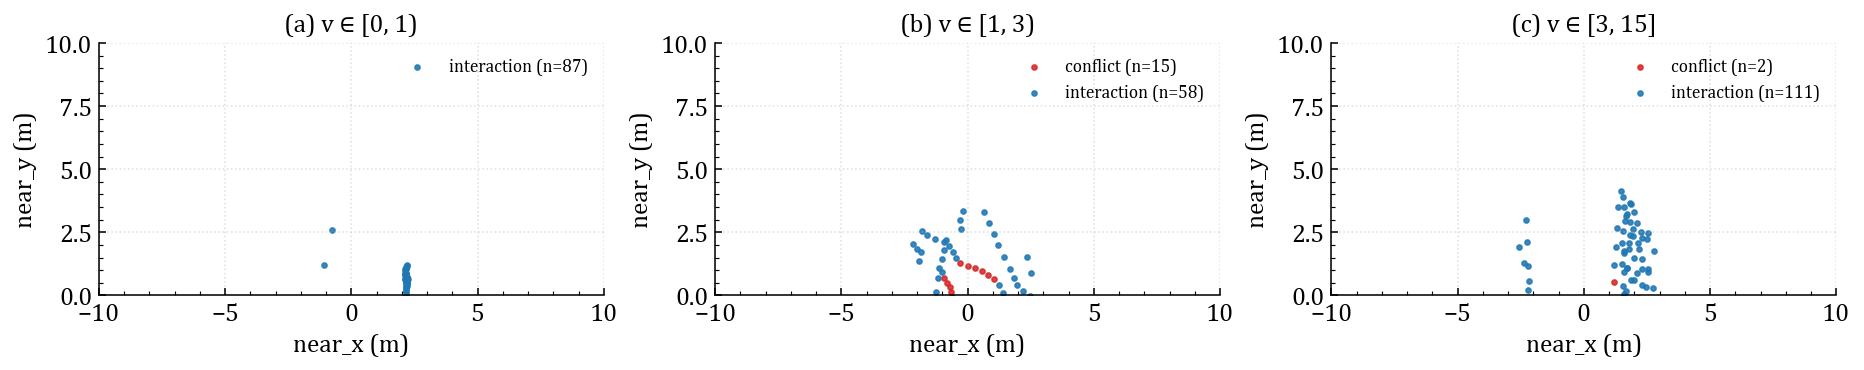

In [28]:
assert len(res_list) >= 3, "res_list 至少需要包含 3 组参数（对应三段速度层）"
ci_label = np.full(len(df_xian), 'other', dtype=object)  # 默认 other，不参与作图
for idx, (_, mask_fn) in enumerate(speed_bins):
    m = mask_fn(v)               # 当前层样本掩码
    if not np.any(m):
        continue
    a = float(res_list[idx]['a']); b = float(res_list[idx]['b'])
    mu = float(res_list[idx]['mu']); sigma = float(res_list[idx]['sigma'])
    rho = np.sqrt((x[m]/a)**2 + (y[m]/b)**2)
    rho_c, rho_b, rho_a = rho_keypoints(mu, sigma)
    # 本层内局部掩码（相对 m 的索引）
    conflict_local    = (rho < rho_c)
    interaction_local = (rho >= rho_c) & (rho < rho_b)
    interaction_local_1 = (rho >= rho_b) & (rho < rho_a)
    # 映射回全局索引再赋值
    idx_m = np.flatnonzero(m)
    ci_label[idx_m[conflict_local]]    = 'conflict'
    ci_label[idx_m[interaction_local]] = 'interaction'
    ci_label[idx_m[interaction_local_1]] = 'interaction_1'
df_xian['ci_label'] = pd.Categorical(ci_label, categories=['conflict','interaction','interaction_1','other'])
# ========= 可视化：一行三列，仅绘制 conflict 与 interaction =========
COLOR = {'conflict': '#d62728', 'interaction': '#1f77b4'}
fig, axes = plt.subplots(1, 3, figsize=(13.2, 4.2), dpi=140, constrained_layout=True)
for ax, (title_txt, mask_fn), letter in zip(axes, speed_bins, "abc"):
    sub = df_xian[mask_fn(df_xian['v'])].copy()
    ax.set_title(f"({letter}) {title_txt}")
    ax.set_xlabel("near_x (m)")
    ax.set_ylabel("near_y (m)")
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-ub, ub)
    ax.set_ylim(0, ub)
    ax.grid(True, ls=":", alpha=0.4)
    if len(sub) == 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
        continue

    for lab in ['conflict', 'interaction']:
        m_lab = (sub['ci_label'] == lab)
        if m_lab.any():
            ax.scatter(sub.loc[m_lab, 'near_x'], sub.loc[m_lab, 'near_y'],
                       s=6, alpha=0.85, c=COLOR[lab], label=f"{lab} (n={m_lab.sum()})")
    ax.legend(loc="upper right", frameon=False, fontsize=9)
plt.show()

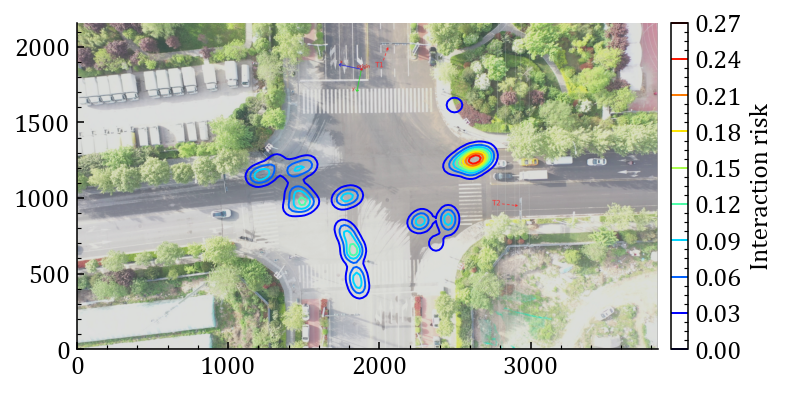

In [29]:
# ===== 基本参数：背景图 & 像素映射（保持与你一致）=====
W, H = 3840, 2160
X_L, X_R = 94.66,69.66
Y_T, Y_B =20.94,74.45 
sx = W / (X_L + X_R)
sy = H / (Y_T + Y_B)
# ===== 1) 筛选 + 定义冲突风险 =====
df_sub = df_xian[df_xian['ci_label'].astype('string').isin(['interaction','conflict'])].copy()
df_sub = df_sub[np.isfinite(df_sub['comfort'])]
x = -df_sub['comfort'].to_numpy(dtype=float)
risk_norm = (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x) + 1e-12)
df_sub['risk_norm'] = risk_norm
# 坐标映射到像素
x_px = df_sub['x_car'].to_numpy() * sx + X_L * sx
y_px = df_sub['y_car'].to_numpy() * sy + Y_T * sy+100
# ===== 2) 在像素网格上求每格平均风险 =====
nx, ny =190,105  # 网格分辨率
# 权重求和（风险之和）
sum_risk, xedges, yedges = np.histogram2d(
    x_px, y_px, bins=[nx, ny], range=[[0, W], [0, H]], weights=risk_norm)
# 计数
cnt, _, _ = np.histogram2d(
    x_px, y_px, bins=[nx, ny], range=[[0, W], [0, H]])
# 平均风险（避免除零）
mean_risk = np.full_like(sum_risk, np.nan, dtype=float)
m = cnt > 0
mean_risk[m] = sum_risk[m] / cnt[m]
# 转为 (ny, nx)，并取网格中心点
Z = mean_risk.T
xc = 0.5 * (xedges[:-1] + xedges[1:])
yc = 0.5 * (yedges[:-1] + yedges[1:])
Xc, Yc = np.meshgrid(xc, yc, indexing='xy')  # 形状 (ny, nx)
finite_Z = Z[np.isfinite(Z)]
if finite_Z.size == 0:
    raise RuntimeError("No finite risk values to contour. Check data or bins.")
levels = np.quantile(finite_Z, np.linspace(0.15, 0.95, 9))  # 9条等势线
# ===== 5) 叠加到底图，用 contour 可视化等势线 =====
fig, ax = plt.subplots(figsize=(6,3), dpi=140)
img = plt.imread(r'C:/Users/14487/python-book/驾驶员让行模拟论文/第一轮修改/SinD/Xian_shanglin/Xian_Shanglin.png')
ax.imshow(img, extent=[0, W, 0, H], origin='upper', alpha=0.85, zorder=1)
# Z 是你要等高线的二维网格（形状 ~ (ny, nx)）
Z[np.isnan(Z)] = 0.01
Z_smooth = gaussian_filter(Z, sigma=2, mode='nearest')  # sigma≈2–4 个网格为常用范围
CS = ax.contour( Xc, Yc, Z_smooth, levels=8, cmap='jet', linewidths=1, zorder=2)
cbar = plt.colorbar(CS, ax=ax, fraction=0.027, pad=0.02)
cbar.set_label('Interaction risk')
ax.set_xlim(0, W)
ax.set_ylim(0, H)            # 与 origin='upper' 一致，上小下大
plt.tight_layout()
plt.savefig('xian_conflict_risk_contour.png', dpi=220, bbox_inches='tight')
plt.show()

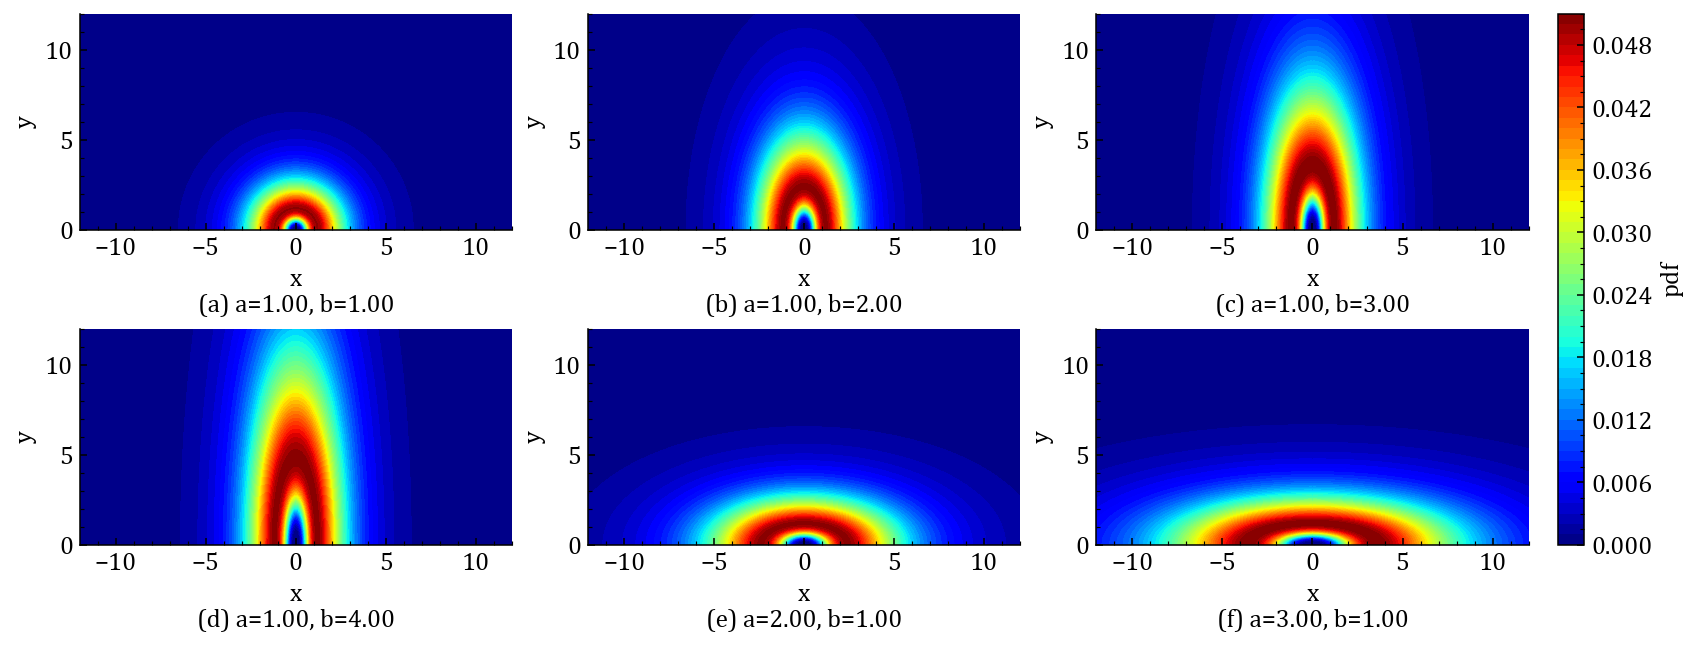

In [30]:
# ----- 固定 mu, sigma：从第一组结果取，或手工指定 -----
mu    = float(res_list[0]['mu'])      # 或者直接写死，例如 mu = 1.0
sigma = float(res_list[0]['sigma'])   # 或者 sigma = 0.6
# ----- a, b 序列；这里只用前三对作为三幅子图 -----
a_vals = [1, 1, 1, 1, 2, 3]
b_vals = [1, 2, 3, 4,1, 1, 1,]
param_sets = list(zip(a_vals, b_vals))   # -> (1,1), (1,2), (1,3)
# 画布与域
fig, axes = plt.subplots(2,3, figsize=(12,4.5), constrained_layout=True, dpi=140)
axes = np.ravel(axes)
ub = 12.0
RENORMALIZE_TO_NEW_DOMAIN = False
mappable = None
for i, (ax, (a, b)) in enumerate(zip(axes, param_sets)):
    # 组装 res（只用 a,b,mu,sigma）
    res = {'a': a, 'b': b, 'mu': mu, 'sigma': sigma}
    # 第一象限的归一化密度
    xs, ys, pdf = normalized_pdf_grid_lognorm(res, ub=ub, Mx=420, My=420)
    xs_full  = np.concatenate((-xs[1:][::-1], xs), axis=0)
    pdf_full = np.concatenate((pdf[:, 1:][:, ::-1], pdf), axis=1)
    if RENORMALIZE_TO_NEW_DOMAIN:
        pdf_full = pdf_full / 2.0
    cf = ax.contourf(xs_full, ys, pdf_full, levels=50, cmap='jet')
    mappable = cf
    ax.set_xlabel(f"x\n({string.ascii_lowercase[i]}) a={a:.2f}, b={b:.2f}")
    ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-ub, ub); ax.set_ylim(0, ub)
# 共享色条：等高
cbar = fig.colorbar(mappable, ax=axes.tolist(), label="pdf",location='right', shrink=1, use_gridspec=True,fraction=0.045, pad=0.02)
plt.savefig('two.png')
plt.show()

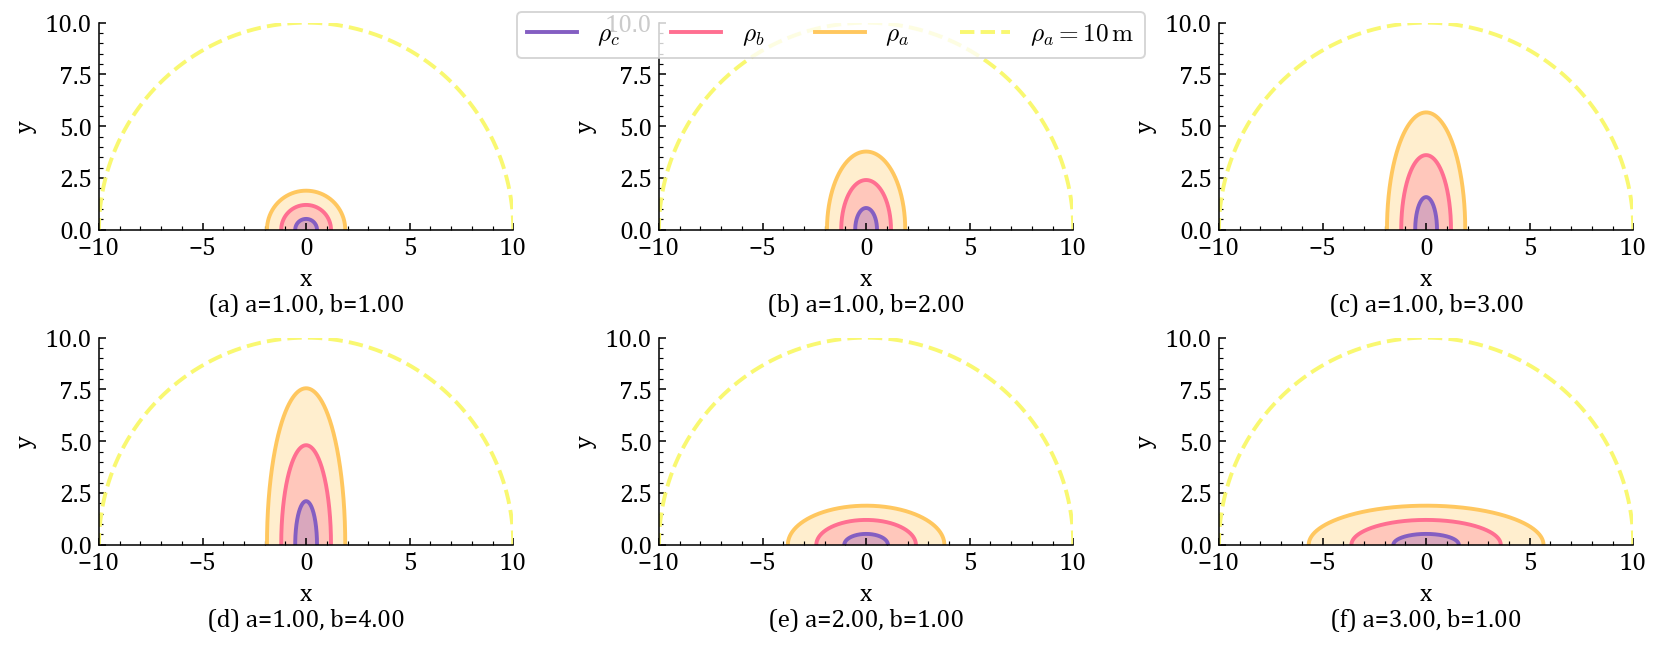

In [31]:
# ============= 1) 参数：mu, sigma（优先从 res_list 读取；否则使用兜底值） =============
try:
    mu    = float(res_list[0]['mu'])      # 例如：1.0
    sigma = float(res_list[0]['sigma'])   # 例如：0.6
except Exception:
    mu, sigma = 1.0, 0.6  # 兜底：若没有 res_list，就用默认值

# ============= 2) (a,b) 参数组与画布设置 =============
a_vals = [1, 1, 1, 1, 2, 3]
b_vals = [1, 2, 3, 4, 1, 1]
param_sets = list(zip(a_vals, b_vals))

fig, axes = plt.subplots(2, 3, figsize=(12, 4.5), constrained_layout=True, dpi=140)
axes = np.ravel(axes)

# 画布显示范围：为避免 10 m 半圆被裁剪，适当放大边界
ub = 10  # x ∈ [-ub, ub], y ∈ [0, ub]

# ============= 3) 颜色与样式 =============
COL1 = "#845ec2"  # 导数最大（内环）
COL2 = "#ff6f91"  # 导数 = 0（中环）
COL3 = "#ffc75f"  # 导数最小（外环）
ALPHA_FILL = 0.30

# 10 m 上半圆样式
R_CIRCLE = 10.0
COL_CIRC = "#f9f871"
LS_CIRC  = "--"
LW_CIRC  = 2.0

# ============= 4) 三条环对应的 rho 计算（与你给出的公式一致） =============
sig2  = sigma**2
Delta = np.sqrt(1.0 + 4.0/sig2)
B_plus  = (-1.0 + Delta)/2.0   # 外侧拐点（导数最小）
B_minus = (-1.0 - Delta)/2.0   # 内侧拐点（导数最大）
rho_inner = np.exp(mu + sig2*(B_minus - 2.0))  # 导数最大（内环） -> ρ_c
rho_mid   = np.exp(mu - 2.0*sig2)              # 导数 = 0（中环） -> ρ_b
rho_outer = np.exp(mu + sig2*(B_plus  - 2.0))  # 导数最小（外环） -> ρ_a

# 只在上半平面绘制（θ ∈ [0, π]）
theta = np.linspace(0.0, np.pi, 800)

def ellipse_arc(a, b, rho):
    """返回上半椭圆弧坐标：x = a*rho*cosθ, y = b*rho*sinθ"""
    x = a * rho * np.cos(theta)
    y = b * rho * np.sin(theta)
    return x, y

def fill_inside_half_ellipse(ax, a, b, rho, color, alpha=ALPHA_FILL):
    """
    在上半平面填充“半椭圆内区域”：沿弧线闭合到 x 轴，从 (-a*rho,0) 返回到 (a*rho,0)。
    得到 { (x,y): y>=0 且 (x/a)^2 + (y/b)^2 <= rho^2 }。
    """
    x_arc, y_arc = ellipse_arc(a, b, rho)
    # 闭合到 x 轴（从右端点接 0，再回到左端点的 0）
    x_poly = np.concatenate([x_arc, [x_arc[-1], x_arc[0]]])
    y_poly = np.concatenate([y_arc, [0.0,       0.0      ]])
    ax.fill(x_poly, y_poly, color=color, alpha=alpha, linewidth=0)

def plot_ring(ax, a, b, rho, color, lw=2.0, ls='-'):
    """绘制半椭圆弧（环）"""
    x, y = ellipse_arc(a, b, rho)
    ax.plot(x, y, color=color, lw=lw, ls=ls)

def plot_semicircle(ax, R, color=COL_CIRC, lw=LW_CIRC, ls=LS_CIRC):
    """绘制以原点为中心、半径 R 的上半圆弧（y>=0）"""
    x = R * np.cos(theta)
    y = R * np.sin(theta)
    ax.plot(x, y, color=color, lw=lw, ls=ls)

# ============= 5) 主循环：每个 (a,b) 子图 =============
for i, (ax, (a, b)) in enumerate(zip(axes, param_sets)):
    # 先由外到内填色，便于形成三段带状区域
    fill_inside_half_ellipse(ax, a, b, rho_outer, COL3, alpha=ALPHA_FILL)
    fill_inside_half_ellipse(ax, a, b, rho_mid,   COL2, alpha=ALPHA_FILL)
    fill_inside_half_ellipse(ax, a, b, rho_inner, COL1, alpha=ALPHA_FILL)

    # 再画三条线（从内到外：ρ_c, ρ_b, ρ_a）
    plot_ring(ax, a, b, rho_inner, COL1, lw=2.0, ls='-')  # ρ_c（内）
    plot_ring(ax, a, b, rho_mid,   COL2, lw=2.0, ls='-')  # ρ_b（中）
    plot_ring(ax, a, b, rho_outer, COL3, lw=2.0, ls='-')  # ρ_a（外）

    # 10 m 上半圆
    plot_semicircle(ax, R_CIRCLE, color=COL_CIRC, lw=LW_CIRC, ls=LS_CIRC)

    # 坐标与外观
    ax.set_xlabel(f"x\n({string.ascii_lowercase[i]}) a={a:.2f}, b={b:.2f}")
    ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-ub, ub)
    ax.set_ylim(0, ub)
    ax.grid(False)
# ============= 6) 统一图例（从内到外 + 10 m 圆） =============
handles = [
    plt.Line2D([], [], color=COL1, lw=2.0, label=r"$\rho_{c}$"),
    plt.Line2D([], [], color=COL2, lw=2.0, label=r"$\rho_{b}$"),
    plt.Line2D([], [], color=COL3, lw=2.0, label=r"$\rho_{a}$"),
    plt.Line2D([], [], color=COL_CIRC, lw=LW_CIRC, ls=LS_CIRC, label=r"$\rho_{a}=10\,\mathrm{m}$"),
]
fig.legend(handles=handles, loc='upper center', ncol=4, frameon=True)
# ============= 7) 展示 / 保存 =============
plt.savefig('two_ring_with_10m_circle.png', dpi=220, bbox_inches='tight')
plt.show()

In [32]:
df=pd.read_csv('C:/Users/14487/python-book/safetyspace/absolute_ped/r_distance_all.csv')

In [36]:
df.columns

Index(['Unnamed: 0', 'tt', 'id_mor', 'yy_mor', 'xx_mor', 'v_x_mor', 'v_y_mor',
       'v_mor', 'id_ped', 'yy_ped', 'xx_ped', 'v_x_ped', 'v_y_ped', 'v_ped',
       'x_v', 'y_v', 'v', 'rel_x', 'rel_y', 'near_x', 'near_y'],
      dtype='object')

In [94]:
df_xian

Unnamed: 0     track_id_car          frame_id  timestamp_ms_car  \
980           980   xian_412_m1_17    xian_412_m1_86       8608.608609   
2682         2682    xian_412_m1_3    xian_412_m1_76       7607.607608   
2683         2683    xian_412_m1_3    xian_412_m1_78       7807.807808   
2684         2684    xian_412_m1_3    xian_412_m1_80       8008.008008   
2685         2685    xian_412_m1_3    xian_412_m1_82       8208.208208   
...           ...              ...               ...               ...   
77357       77357  xian_415_n4_289  xian_415_n4_6283     628928.928929   
77358       77358  xian_415_n4_289  xian_415_n4_6285     629129.129129   
77359       77359  xian_415_n4_289  xian_415_n4_6287     629329.329329   
77360       77360  xian_415_n4_289  xian_415_n4_6289     629529.529530   
77361       77361  xian_415_n4_289  xian_415_n4_6291     629729.729730   

      agent_type_car      x_car      y_car    vx_car    vy_car   yaw_rad  ...  \
980       motorcycle -30.046631  32.728242 -6.125557 -1.557354 -2.892033  ...   
2682      motorcycle -37.393760  29.640976 -8.625962 -2.154743 -2.896501  ...   
2683      motorcycle -38.933612  29.203339 -8.520817 -2.097652 -2.899981  ...   
2684      motorcycle -40.584176  28.745560 -8.681349 -2.124199 -2.900080  ...   
2685      motorcycle -42.425381  28.247302 -8.939780 -2.181367 -2.900010  ...   
...              ...        ...        ...       ...       ...       ...  ...   
77357        bicycle  18.372513  44.222658  3.347898 -1.264170 -0.372193  ...   
77358        bicycle  18.999619  43.957329  3.414331 -1.235205 -0.366036  ...   
77359        bicycle  19.663362  43.707896  3.533107 -1.239829 -0.328474  ...   
77360        bicycle  20.348118  43.521883  3.677719 -1.276207 -0.342861  ...   
77361        bicycle  21.185770  43.251776  3.919664 -1.285267 -0.355069  ...   

            y_v         v     v_ego     rel_x     rel_y    near_x    near_y  \
980    0.260034  2.583091  6.320427 -9.155329 -2.293331  0.033251  9.438131   
2682  -0.155617  4.525694  8.891015  1.924266  2.711399  2.164222 -2.524010   
2683  -0.058179  4.395989  8.775219  2.630199  2.738469  2.030349 -3.208558   
2684  -0.024532  4.558379  8.937451  3.355905  2.670659  1.796520 -3.894487   
2685  -0.116631  4.979037  9.202066  4.572724  2.823795  1.659335 -5.111774   
...         ...       ...       ...       ...       ...       ...       ...   
77357 -0.126472  3.010968  3.578624 -2.103142 -8.784926  8.961480  1.135782   
77358 -0.087091  3.005899  3.630893 -2.613250 -8.760847  9.127321  0.522996   
77359 -0.097458  3.141544  3.744332 -3.190115 -8.732722  9.296408 -0.118562   
77360 -0.162999  3.431215  3.892855 -3.869395 -8.757293  9.541843 -0.784625   
77361 -0.210766  3.924614  4.125006 -4.860533 -8.693154  9.774851 -1.909969   

       Distance   comfort       ci_label  
980    9.438189  0.001298          other  
2682   3.324828  0.003658    interaction  
2683   3.796993  0.003713    interaction  
2684   4.288883  0.003724  interaction_1  
2685   5.374349  0.003542  interaction_1  
...         ...       ...            ...  
77357  9.033168  0.000669          other  
77358  9.142292  0.000636          other  
77359  9.297164  0.000601          other  
77360  9.574048  0.000549          other  
77361  9.959704  0.000496          other  

[2484 rows x 53 columns]

           conflict rate (rho∈(0, rho_c))  \
Xian                                 0.68   
Chongqing                            5.21   
Changchun                            1.73   
Tianjin                             34.04   

           interaction rate (rho∈(rho_c, rho_b))  \
Xian                                       10.31   
Chongqing                                   7.95   
Changchun                                  10.90   
Tianjin                                    12.09   

           buffer zone rate (rho∈(rho_c, rho_a))  \
Xian                                       30.48   
Chongqing                                  20.23   
Changchun                                  29.98   
Tianjin                                    24.59   

           clearance zone rate (rho>rho_a)  
Xian                                 68.84  
Chongqing                            74.56  
Changchun                            68.29  
Tianjin                              41.37  


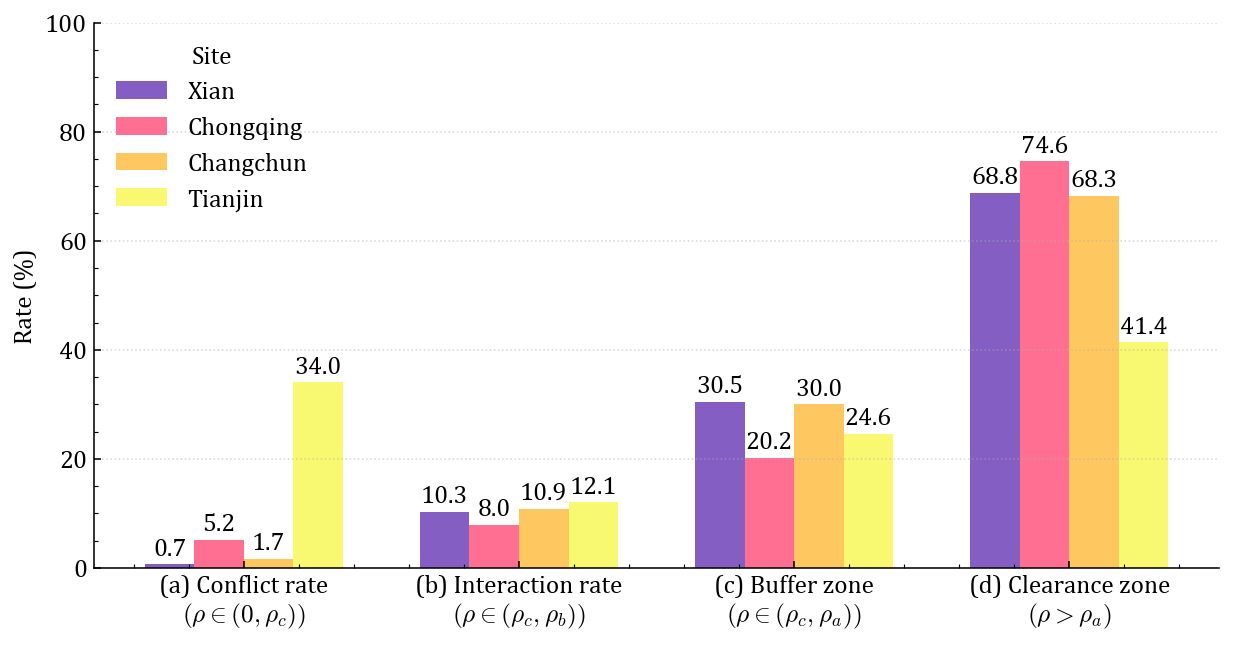

In [34]:

# === 1) 一个小函数：从 ci_label 统计所需比例（百分比） ===
def compute_rates_from_ci(df: pd.DataFrame) -> pd.Series:
    """
    期望 df 里有一列 'ci_label'，取值于:
      {'conflict','interaction','interaction_1','other'}
    返回四个比例（百分比）：
      - conflict rate (rho∈(0, rho_c))
      - interaction rate (rho∈(rho_c, rho_b))
      - buffer zone rate (rho∈(rho_c, rho_a)) = interaction + interaction_1
      - clearance zone rate (rho>rho_a) = other
    """
    if len(df) == 0:
        return pd.Series({
            "conflict rate (rho∈(0, rho_c))": 0.0,
            "interaction rate (rho∈(rho_c, rho_b))": 0.0,
            "buffer zone rate (rho∈(rho_c, rho_a))": 0.0,
            "clearance zone rate (rho>rho_a)": 0.0,
        })

    lab = df["ci_label"].astype("string").fillna("other")
    n = float(len(lab))
    cnt = lab.value_counts()

    n_conf = int(cnt.get("conflict", 0))
    n_int  = int(cnt.get("interaction", 0))
    n_int1 = int(cnt.get("interaction_1", 0))
    n_oth  = int(cnt.get("other", 0))

    return pd.Series({
        "conflict rate (rho∈(0, rho_c))": 100.0 * n_conf / n,
        "interaction rate (rho∈(rho_c, rho_b))": 100.0 * n_int / n,
        "buffer zone rate (rho∈(rho_c, rho_a))": 100.0 * (n_int + n_int1) / n,  # interaction + interaction_1
        "clearance zone rate (rho>rho_a)": 100.0 * n_oth / n,                   # other
    })

# === 2) 对四个地点分别统计 ===
site_dfs = {
    "Xian": df_xian,
    "Chongqing": df_chongqing,
    "Changchun": df_changchun,
    "Tianjin": df_tianjin,
}

rates = {name: compute_rates_from_ci(df) for name, df in site_dfs.items()}
rates_df = pd.DataFrame(rates).T  # 行=地点，列=四个比例
print(rates_df.round(2))

# === 3) 画一张分组柱状图（每个横轴类别对应四个城市的柱） ===
fig, ax = plt.subplots(figsize=(9, 4.8), dpi=140)

cols = [
    "conflict rate (rho∈(0, rho_c))",
    "interaction rate (rho∈(rho_c, rho_b))",
    "buffer zone rate (rho∈(rho_c, rho_a))",
    "clearance zone rate (rho>rho_a)",
]
X = np.arange(len(cols))
W = 0.18  # 单柱宽度
color=['#845ec2','#ff6f91','#ffc75f','#f9f871']
for i, site in enumerate(rates_df.index):
    ax.bar(X + (i - 1.5)*W, rates_df.loc[site, cols].values, width=W, label=site,color=color[i])

ax.set_xticks(X)
ax.set_xticklabels([
    r"(a) Conflict rate"   "\n" r"$(\rho \in (0,\rho_c))$",
    r"(b) Interaction rate""\n" r"$(\rho \in (\rho_c,\rho_b))$",
    r"(c) Buffer zone"     "\n" r"$(\rho \in (\rho_c,\rho_a))$",
    r"(d) Clearance zone"  "\n" r"$(\rho > \rho_a)$",
], rotation=0)
ax.set_ylabel("Rate (%)")
ax.set_ylim(0, 100)
ax.grid(axis="y", linestyle=":", alpha=0.5)
ax.legend(title="Site", frameon=False)

# 给每根柱加数值标签
for c in ax.containers:
    ax.bar_label(c, fmt="%.1f", padding=2)

fig.tight_layout()
plt.savefig('show.png', dpi=200, bbox_inches='tight')
plt.show()

In [42]:
# === 3) 一行四列子图：每个子图显示一个指标，横轴为四个城市 ===
import matplotlib.patches as mpatches

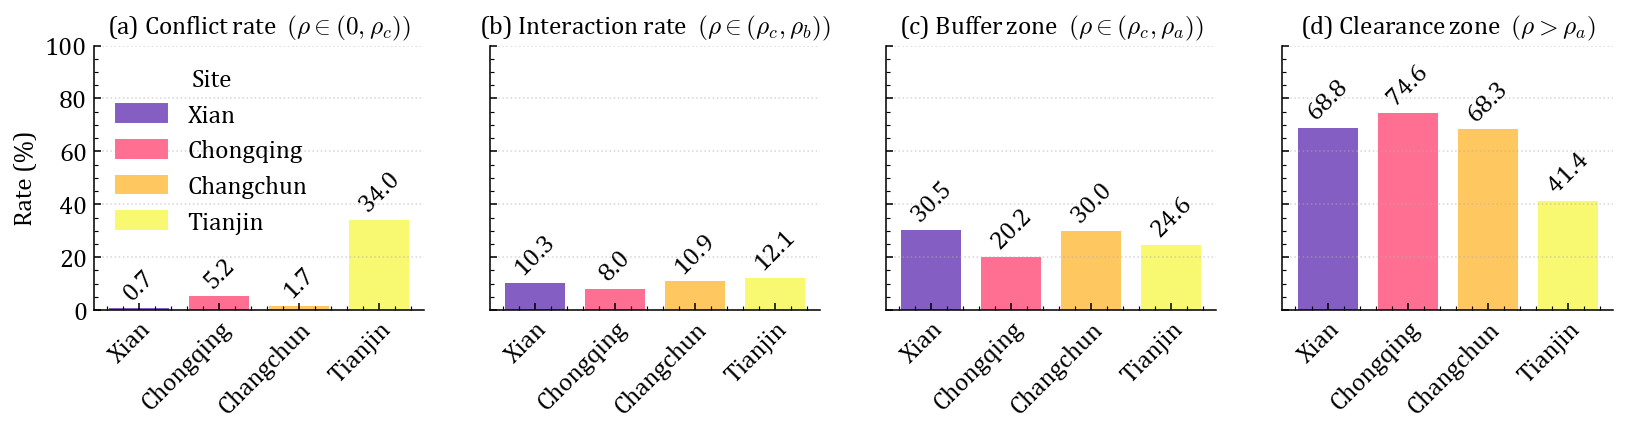

In [52]:
# ... 前面代码不变 ...

fig, axes = plt.subplots(1, 4, figsize=(14,3), dpi=140, sharey=True)
x = np.arange(len(site_names))
bar_width = 0.75

for j, (col, title) in enumerate(zip(cols, titles)):
    ax = axes[j]
    heights = [rates_df.loc[site, col] for site in site_names]
    bars = ax.bar(
        x, heights,
        width=bar_width,
        color=[color_map[s] for s in site_names]
    )

    ax.set_xticks(x)
    # 直接在这里把标签旋转 45 度，右对齐
    ax.set_xticklabels(site_names, rotation=45, ha='right', rotation_mode='anchor')

    ax.set_ylim(0, 100)
    ax.set_title(title)
    ax.grid(axis="y", linestyle=":", alpha=0.5)
    ax.bar_label(bars, fmt="%.1f", padding=2, rotation=45)

# 统一Y轴标签只在第一个子图显示
axes[0].set_ylabel("Rate (%)")

legend_handles = [mpatches.Patch(color=color_map[s], label=s) for s in site_names]
axes[0].legend(handles=legend_handles, title="Site", frameon=False, loc="upper left")

# 底部留白，避免斜标签被截断
plt.subplots_adjust(bottom=0.25)
plt.savefig('show_4.png', dpi=200, bbox_inches='tight')
plt.show()
